In [567]:
!python3 -m pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable


In [568]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, balanced_accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from IPython.display import display


In [569]:
RANDOM_STATE   = 42
PREDICT_MONTH  = pd.Period('2023-07', 'M')   # month to predict
TRAIN_END   = pd.Period('2023-06', 'M')   # last month with labels for training
SHIFT_MACRO_BY = 1


In [570]:
stock = pd.read_csv("stock_data.csv")
index  = pd.read_csv("monashIndex.csv")
company  = pd.read_csv("company_info.csv")
vix    = pd.read_csv("vix_index.csv")
us10yt     = pd.read_csv("us_10_year_treasury.csv")
us5yt      = pd.read_csv("us_5_year_treasury.csv")
infl     = pd.read_csv("fed_inflation_rate.csv")
fedfunds = pd.read_csv("fed_funds_rate.csv")
unemp     = pd.read_csv("fed_unemployment_rate.csv")
train_tgt= pd.read_csv("training_targets.csv").astype({"stock_id":"str"})
test_tgt  = pd.read_csv("testing_targets.csv").astype({"stock_id":"str"})


In [571]:
# === Cálculo explícito de retornos mensuales y excess return (método del enunciado) ===
# Usa exactamente tus columnas y dataframes:
# - DataFrame de acciones: stock
# - DataFrame del índice:  index
# - Columnas: month_start_open_usd, month_end_close_usd, index_return
# - Claves temporales y de id: stock_id, month_id

# 1) Validaciones rápidas de columnas
req_stock_cols = ["stock_id", "month_id", "month_start_open_usd", "month_end_close_usd"]
missing_stock = [c for c in req_stock_cols if c not in stock.columns]
if missing_stock:
    raise ValueError(f"Faltan columnas en 'stock': {missing_stock}")

req_index_cols = ["month_id", "index_return"]
missing_index = [c for c in req_index_cols if c not in index.columns]
if missing_index:
    raise ValueError(f"Faltan columnas en 'index': {missing_index}")

# 2) Cálculo del retorno mensual del stock (en %):
#    stock_return_calc = ((Close_fin_de_mes - Open_inicio_de_mes) / Open_inicio_de_mes) * 100
stock = stock.copy()
stock["stock_return_calc"] = (
    (stock["month_end_close_usd"] - stock["month_start_open_usd"])
    / stock["month_start_open_usd"]
) * 100.0

# 3) Calcular excess_return_calc = stock_return_calc - index_return (por mes)
#    Para no contaminar nada, lo hacemos en un DF auxiliar y luego lo acoplamos.
_excess_tmp = (
    stock[["stock_id", "month_id", "stock_return_calc"]]
    .merge(index[["month_id", "index_return"]], on="month_id", how="left")
    .assign(excess_return_calc=lambda d: d["stock_return_calc"] - d["index_return"])
)

# 4) Adjuntar los cálculos a 'stock' (útil para QA/gráficas)
stock = stock.merge(
    _excess_tmp[["stock_id", "month_id", "stock_return_calc", "excess_return_calc"]],
    on=["stock_id", "month_id"],
    how="left"
)

# 5) (Recomendado) Usar el valor calculado como verdad de referencia en train_tgt
#    - Lo unimos por (stock_id, month_id)
#    - Conservamos 'excess_return' original si quieres auditar, pero por defecto lo sobreescribimos
train_tgt = train_tgt.merge(
    _excess_tmp[["stock_id", "month_id", "excess_return_calc"]],
    on=["stock_id", "month_id"],
    how="left"
)

# 5.a) QA opcional: ver discrepancias si ya venía 'excess_return' en training_targets.csv
if "excess_return" in train_tgt.columns:
    _diff = (train_tgt["excess_return"] - train_tgt["excess_return_calc"]).abs()
    n_bad = int((_diff > 1e-6).sum())
    print(f"[QA] Filas con diferencia entre 'excess_return' y el recalculado (>1e-6): {n_bad}")

# 5.b) Forzar a usar el método del enunciado:
train_tgt["excess_return"] = train_tgt["excess_return_calc"]
# Regenerar el label binario a partir del excess_return recalculado
train_tgt["outperform_binary"] = (train_tgt["excess_return"] > 0).astype(int)

# Limpieza de columna auxiliar
train_tgt = train_tgt.drop(columns=["excess_return_calc"])


[QA] Filas con diferencia entre 'excess_return' y el recalculado (>1e-6): 25599


In [572]:
def lag_and_roll(df, col, l1=True, mean3=True, time_col="month_id"):
    """Compute lag-1 and rolling-3-month mean features for a time series column, sorted by a time column (default: month_id). Returns a DataFrame with month_id and derived features."""
    df = df.sort_values(time_col).copy()
    out = pd.DataFrame({time_col: df[time_col]})
    if l1:
        out[f"{col}_lag1"] = df[col].shift(1)
    if mean3:
        out[f"{col}_mean_3m"] = df[col].shift(1).rolling(3, min_periods=1).mean()
    return out
vix_feat = lag_and_roll(vix, "vix")  # vix_lag1, vix_mean_3m
yields = (us10yt.merge(us5yt, on="month_id", how="outer")
            .sort_values("month_id"))
yields_feat = yields[["month_id"]].copy()
yields_feat["y10_lag1"] = yields["10y_treasury"].shift(1)
yields_feat["y5_lag1"]  = yields["5y_treasury"].shift(1)
yields_feat["term_slope_lag1"] = yields_feat["y10_lag1"] - yields_feat["y5_lag1"]
fed = fedfunds.sort_values("month_id")
fed_feat = fed[["month_id"]].copy()
fed_feat["fed_rate_lag1"]   = fed["fed_rate"].shift(1)
fed_feat["fed_rate_chg_3m"] = fed["fed_rate"].shift(1) - fed["fed_rate"].shift(4)
cpi_feat = lag_and_roll(infl, "inflation_rate")  # inflation_rate_lag1, inflation_rate_mean_3m
cpi_feat = cpi_feat.rename(columns={
    "inflation_rate_lag1": "inflation_rate_lag1",
    "inflation_rate_mean_3m": "inflation_3m_mean"
})
unemp = unemp.sort_values("month_id")
unemp_feat = unemp[["month_id"]].copy()
unemp_feat["unemployment_rate_lag1"] = unemp["unemployment_rate"].shift(1)
idx = index.sort_values("month_id")
idx_feat = idx[["month_id"]].copy()
idx_feat["index_return_lag1"]     = idx["index_return"].shift(1)
idx_feat["index_return_mean_3m"]  = idx["index_return"].shift(1).rolling(3, min_periods=1).mean()
roll_max = idx["index_value"].shift(1).rolling(3, min_periods=1).max()
idx_feat["index_value_dd_3m"] = (idx["index_value"].shift(1) - roll_max) / roll_max
macro_feat = (
    vix_feat.merge(yields_feat, on="month_id", how="outer")
            .merge(fed_feat, on="month_id", how="outer")
            .merge(cpi_feat, on="month_id", how="outer")
            .merge(unemp_feat, on="month_id", how="outer")
            .merge(idx_feat, on="month_id", how="outer")
            .sort_values("month_id")
)
print("macro_feat shape:", macro_feat.shape)


macro_feat shape: (42, 14)


In [573]:
stock = stock.sort_values(["stock_id", "month_id"]).copy()
to_lag = [
    "month_start_open_usd","month_end_close_usd",
    "month_high_usd","month_low_usd",
    "monthly_volume","intramonth_return","intramonth_volatility",
    "return_1m","return_3m","return_6m",
    "volatility_3m","volatility_6m",
    "trading_days","avg_volume_3m","volume_ratio","price_range_ratio"
]
missing_cols = [c for c in to_lag if c not in stock.columns]
if missing_cols:
    raise ValueError(f"Missing columns in stock_data.csv: {missing_cols}")
lagged = stock.groupby("stock_id")[to_lag].shift(1)
lagged.columns = [f"{c}_lag1" for c in to_lag]
stock_feat = pd.concat([stock[["stock_id","month_id"]], lagged], axis=1)
stock_feat = stock_feat.dropna(subset=[col for col in stock_feat.columns if col.endswith("_lag1")])
print("stock_feat shape:", stock_feat.shape)


stock_feat shape: (24867, 18)


In [574]:
### BEGIN PATCH 1: monthly returns & targets (required) ###
# Requiere columnas numéricas:
# - stock: ['stock_id','month_id','month_start_open_usd','month_end_close_usd']
# - index: ['month_id','index_return']  # % mensual del Monash Index
# Si tus columnas tienen otros nombres, ajusta aquí.

stock = stock.sort_values(["stock_id", "month_id"]).copy()

stock["stock_return"] = (
    (stock["month_end_close_usd"] - stock["month_start_open_usd"])
    / stock["month_start_open_usd"]
) * 100.0

panel = (
    stock.merge(index[["month_id", "index_return"]], on="month_id", how="left")
          .copy()
)

panel["excess_return_calc"] = panel["stock_return"] - panel["index_return"]
panel["outperform_binary"] = (panel["excess_return_calc"] > 0).astype(int)

# (Opcional) Verificación si ya existía alguna columna previa:
if "excess_return" in panel.columns:
    chk = (panel["excess_return_calc"] - panel["excess_return"]).abs().mean()
    print(f"[Check] Δ MAE vs columna existente 'excess_return': {chk:.6f}")

print(panel[["stock_id","month_id","stock_return","index_return",
             "excess_return_calc","outperform_binary"]].head())
### END PATCH 1 ###


  stock_id month_id  stock_return  index_return  excess_return_calc  \
0    US001  2020_01    -10.704539     -0.006452          -10.698088   
1    US001  2020_02     -5.897351     -0.053054           -5.844297   
2    US001  2020_03     -9.799518     -0.111379           -9.688139   
3    US001  2020_04     15.091010      0.141313           14.949697   
4    US001  2020_05      5.820879      0.071232            5.749648   

   outperform_binary  
0                  0  
1                  0  
2                  0  
3                  1  
4                  1  


In [575]:
# Ensure macro_feat exists before use; build from macro tables if needed
if 'macro_feat' not in globals():
    # Build base macro table if absent
    if 'macro' not in globals():
        macro = (
            vix[['month_id','vix']]
            .merge(us10yt[['month_id','10y_treasury']], on='month_id', how='outer')
            .merge(us5yt[['month_id','5y_treasury']], on='month_id', how='outer')
            .merge(infl[['month_id','inflation_rate']], on='month_id', how='outer')
            .merge(fedfunds[['month_id','fed_rate']], on='month_id', how='outer')
            .merge(unemp[['month_id','unemployment_rate']], on='month_id', how='outer')
            .merge(index[['month_id','index_return','index_value']], on='month_id', how='outer')
            .sort_values('month_id')
        )
        # engineering (optional, used by lagging below)
        macro['TERM_SPREAD'] = macro['10y_treasury'] - macro['5y_treasury']
        macro['REAL_RATE_PROXY'] = macro['10y_treasury'] - macro['inflation_rate']
        for c in ['vix','10y_treasury','5y_treasury','inflation_rate','fed_rate','unemployment_rate']:
            macro[c + '_CHG_1M'] = macro[c].diff()
    # Create lag-1 version of all non-id columns
    macro_feat = macro[['month_id']].copy()
    for c in [col for col in macro.columns if col!='month_id']:
        macro_feat[c + '_lag1'] = macro[c].shift(1)

if 'company_ohe' not in globals():
    cat_cols = ['sector','business_model','geographic_focus','business_maturity','competitive_position',
                'market_cap_category','revenue_tier','profitability_profile','asset_intensity','financial_strength']
    comp = company[['stock_id'] + cat_cols].copy()
    company_ohe = pd.get_dummies(comp, columns=cat_cols, prefix=cat_cols, prefix_sep='=')
features_panel = (
    stock_feat
    .merge(macro_feat, on="month_id", how="left")
    .merge(company_ohe, on="stock_id", how="left")
    .sort_values(["stock_id","month_id"])
)
print("features_panel shape:", features_panel.shape)
features_panel.head(3)


features_panel shape: (24867, 70)


,stock_id,month_id,month_start_open_usd_lag1,month_end_close_usd_lag1,month_high_usd_lag1,month_low_usd_lag1,monthly_volume_lag1,intramonth_return_lag1,intramonth_volatility_lag1,return_1m_lag1,...,revenue_tier=Tier_3,profitability_profile=High_Margin,profitability_profile=Low_Margin,profitability_profile=Standard,asset_intensity=Asset_Light,asset_intensity=Capital_Intensive,asset_intensity=Moderate,financial_strength=Developing,financial_strength=Stable,financial_strength=Strong
0,US001,2020_02,120.192,107.326,123.486,107.035,84539259.0,-0.107045,0.253304,-0.100669,...,False,False,False,True,False,False,True,False,True,False
1,US001,2020_03,108.252,101.868,111.641,99.636,91313882.0,-0.058974,0.259208,-0.050854,...,False,False,False,True,False,False,True,False,True,False
2,US001,2020_04,103.301,93.178,105.622,77.841,177930833.0,-0.097995,0.892709,-0.085299,...,False,False,False,True,False,False,True,False,True,False


In [576]:
macro = (
    vix[["month_id", "vix"]]
    .merge(us10yt[["month_id", "10y_treasury"]], on="month_id", how="outer")
    .merge(us5yt[["month_id", "5y_treasury"]], on="month_id", how="outer")
    .merge(infl[["month_id", "inflation_rate"]], on="month_id", how="outer")
    .merge(fedfunds[["month_id", "fed_rate"]], on="month_id", how="outer")
    .merge(unemp[["month_id", "unemployment_rate"]], on="month_id", how="outer")
    .merge(index[["month_id", "index_return", "index_value"]], on="month_id", how="outer")
    .sort_values("month_id")
)
macro["TERM_SPREAD"] = macro["10y_treasury"] - macro["5y_treasury"]
macro["REAL_RATE_PROXY"] = macro["10y_treasury"] - macro["inflation_rate"]
for col in ["vix", "10y_treasury", "5y_treasury", "inflation_rate", "fed_rate", "unemployment_rate"]:
    macro[f"{col}_CHG_1M"] = macro[col].diff()
macro_lag = macro.copy()
macro_cols = [c for c in macro.columns if c != "month_id"]
macro_lag[macro_cols] = macro_lag[macro_cols].shift(1)
macro_lag = macro_lag.rename(columns={c: f"{c}_lag1" for c in macro_cols})


In [577]:
stock = stock.sort_values(["stock_id", "month_id"])


In [578]:
to_lag = [
    "return_1m","return_3m","return_6m",
    "intramonth_volatility","volatility_3m","volatility_6m",
    "volume_ratio","avg_volume_3m","monthly_volume",
    "price_range_ratio","trading_days"
]
to_lag = [c for c in to_lag if c in stock.columns]
for c in to_lag:
    stock[f"{c}_lag1"] = stock.groupby("stock_id")[c].shift(1)
lag_feats = sorted([f"{c}_lag1" for c in to_lag if f"{c}_lag1" in stock.columns])
panel = stock[["stock_id","month_id"] + lag_feats].merge(macro_lag, on="month_id", how="left")
panel = panel.merge(company, on="stock_id", how="left")
# Ensure label column exists (robustness in case it is missing)
if 'outperform_binary' not in train_tgt.columns and 'excess_return' in train_tgt.columns:
    train_tgt = train_tgt.copy()
    train_tgt['outperform_binary'] = (train_tgt['excess_return'] > 0).astype(int)
panel = panel.merge(
    train_tgt[["stock_id","month_id","outperform_binary"]],
    on=["stock_id","month_id"], how="left"
)


In [579]:
def force_period_m(df, col="month_id"):
    """Normalize a date-like column to pandas Period('M'), robust to 'YYYY_MM' and 'YYYY-MM' string formats."""
    if col in df.columns:
        s = df[col].astype(str).str.strip()
        p = pd.to_datetime(s, format="%Y_%m", errors="coerce")
        m = p.isna()
        if m.any():
            p[m] = pd.to_datetime(s[m].str.replace('_', '-', regex=False), format="%Y-%m", errors="coerce")
        df[col] = p.dt.to_period("M")
    return df
stock     = force_period_m(stock)
macro_lag = force_period_m(macro_lag)
train_tgt = force_period_m(train_tgt)
test_tgt  = force_period_m(test_tgt)
panel     = force_period_m(panel)


In [580]:
train_df = (train_tgt
            .merge(panel, on=["stock_id","month_id"], how="inner")
            .sort_values(["stock_id","month_id"]))
prev_m = PREDICT_MONTH - 1
stock_prev = stock.loc[stock["month_id"] == prev_m, ['stock_id'] + to_lag].copy()
stock_prev = stock_prev.rename(columns={c: f'{c}_lag1' for c in to_lag})
stock_prev['month_id'] = PREDICT_MONTH
macro_prev = macro.loc[macro["month_id"] == prev_m].copy()
macro_prev = macro_prev.rename(columns={c: f'{c}_lag1' for c in macro_prev.columns if c != 'month_id'})
macro_prev['month_id'] = PREDICT_MONTH
panel_pred = (stock_prev
               .merge(macro_prev, on='month_id', how='left')
               .merge(company, on='stock_id', how='left'))
test_df  = (test_tgt
            .merge(panel_pred, on=["stock_id","month_id"], how="left")
            .sort_values(["stock_id","month_id"]))
print(train_df["month_id"].min(), train_df["month_id"].max())
print("Unique test months:", sorted(test_df["month_id"].unique().astype(str)))
drop_cols = ["stock_id","month_id","outperform_binary_x","outperform_binary_y","test_outperform","excess_return"]
feat_cols = [c for c in train_df.columns if c not in drop_cols]
X_train = train_df[feat_cols].replace([np.inf, -np.inf], np.nan)
y_train = train_df["outperform_binary_x"].astype(int)
X_test  = test_df[feat_cols].replace([np.inf, -np.inf], np.nan)
print("X_test NA fraction BEFORE fill:", X_test.isna().mean().mean())
print("Top 10 X_test NA columns BEFORE fill:")
print(X_test.isna().mean().sort_values(ascending=False).head(10))
train_medians = X_train.median(numeric_only=True)
X_train = X_train.fillna(train_medians)
X_test  = X_test.fillna(train_medians)
numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
print("X_train/test shapes:", X_train.shape, X_test.shape)
print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)


2020-01 2023-06
Unique test months: ['2023-07']
X_test NA fraction BEFORE fill: 0.43243243243243246
Top 10 X_test NA columns BEFORE fill:
index_value_lag1                 1.0
5y_treasury_lag1                 1.0
5y_treasury_CHG_1M_lag1          1.0
10y_treasury_CHG_1M_lag1         1.0
vix_CHG_1M_lag1                  1.0
REAL_RATE_PROXY_lag1             1.0
TERM_SPREAD_lag1                 1.0
unemployment_rate_CHG_1M_lag1    1.0
index_return_lag1                1.0
unemployment_rate_lag1           1.0
dtype: float64
X_train/test shapes: (25618, 37) (616, 37)
Numeric columns: ['avg_volume_3m_lag1', 'intramonth_volatility_lag1', 'monthly_volume_lag1', 'price_range_ratio_lag1', 'return_1m_lag1', 'return_3m_lag1', 'return_6m_lag1', 'trading_days_lag1', 'volatility_3m_lag1', 'volatility_6m_lag1', 'volume_ratio_lag1', 'vix_lag1', '10y_treasury_lag1', '5y_treasury_lag1', 'inflation_rate_lag1', 'fed_rate_lag1', 'unemployment_rate_lag1', 'index_return_lag1', 'index_value_lag1', 'TERM_SPREAD_la

In [581]:
print("Panel month range:", panel["month_id"].min(), "→", panel["month_id"].max())
print("Counts by month (tail):")
print(panel["month_id"].value_counts().sort_index().tail(6))
missing_cols = [c for c in ["monthly_volume","avg_volume_3m","volume_ratio","price_range_ratio","trading_days"]
                if c not in stock.columns]
if missing_cols:
    print("Missing in stock_data.csv:", missing_cols)


Panel month range: 2020-01 → 2023-06
Counts by month (tail):
month_id
2023-01    616
2023-02    616
2023-03    616
2023-04    616
2023-05    616
2023-06    616
Freq: M, Name: count, dtype: int64


## MODEL 1 — Logistic Regression (Classification)

In [582]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, balanced_accuracy_score, f1_score
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])
pre = ColumnTransformer(
    transformers=[
        ("num", num_pipe, numeric_cols),
        ("cat", cat_pipe, categorical_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)
clf = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    C=1.0,
    random_state=RANDOM_STATE
)
pipe_lr = Pipeline([
    ("pre", pre),
    ("clf", clf)
])
print("X_train/X_test shapes:", X_train.shape, X_test.shape)
pipe_lr.fit(X_train, y_train)
proba = pipe_lr.predict_proba(X_test)[:, 1]
pred  = (proba >= 0.5).astype(int)
preds_lr = test_df[["stock_id","month_id"]].copy()
preds_lr["proba"] = proba
preds_lr["pred"] = pred
y_test_jul = globals().get('y_test_jul', None)
if y_test_jul is not None and y_test_jul.notna().any():
    y_true = y_test_jul.values.astype(int)
    print("LR — July 2023")
    print("  AUC:                ", round(roc_auc_score(y_true, proba), 4))
    print("  Accuracy:           ", round(accuracy_score(y_true, pred), 4))
    print("  Balanced Accuracy:  ", round(balanced_accuracy_score(y_true, pred), 4))
    print("  F1 (positive=1):    ", round(f1_score(y_true, pred), 4))
preds_lr.sort_values("proba", ascending=False).head(10)


X_train/X_test shapes: (25618, 37) (616, 37)


/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWar

,stock_id,month_id,proba,pred
198,US199,2023-07,0.482339,0
176,US177,2023-07,0.477896,0
326,US329,2023-07,0.476432,0
489,US494,2023-07,0.475311,0
582,US605,2023-07,0.475095,0
8,US009,2023-07,0.474710,0
144,US145,2023-07,0.471207,0
260,US262,2023-07,0.466461,0
142,US143,2023-07,0.465559,0
59,US060,2023-07,0.465269,0


In [583]:
display(X_train)
display(X_test)


,avg_volume_3m_lag1,intramonth_volatility_lag1,monthly_volume_lag1,price_range_ratio_lag1,return_1m_lag1,return_3m_lag1,return_6m_lag1,trading_days_lag1,volatility_3m_lag1,volatility_6m_lag1,...,sector,business_model,geographic_focus,business_maturity,competitive_position,market_cap_category,revenue_tier,profitability_profile,asset_intensity,financial_strength
0,2040278.5,0.315078,44100050.0,0.143176,0.007910,0.025938,0.054107,21.0,0.276432,0.300568,...,Industrials,B2B,Domestic,Mature,Market_Leader,Large,Tier_1,Standard,Moderate,Stable
1,3182487.0,0.253304,84539259.0,0.136875,-0.100669,-0.030041,-0.075676,21.0,0.278396,0.201608,...,Industrials,B2B,Domestic,Mature,Market_Leader,Large,Tier_1,Standard,Moderate,Stable
2,3686371.0,0.259208,91313882.0,0.110905,-0.050854,-0.112968,-0.060752,19.0,0.245523,0.192782,...,Industrials,B2B,Domestic,Mature,Market_Leader,Large,Tier_1,Standard,Moderate,Stable
3,5360363.0,0.892709,177930833.0,0.268931,-0.085299,-0.219214,-0.154874,22.0,0.088364,0.213051,...,Industrials,B2B,Domestic,Mature,Market_Leader,Large,Tier_1,Standard,Moderate,Stable
4,5571115.0,0.408352,98448862.0,0.242954,0.112885,-0.033810,-0.062835,21.0,0.366808,0.291241,...,Industrials,B2B,Domestic,Mature,Market_Leader,Large,Tier_1,Standard,Moderate,Stable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25613,386326.0,0.335883,10455200.0,0.134183,0.056930,-0.077414,0.053293,20.0,0.251799,0.496076,...,Finance,B2C,Domestic,Mature,Strong_Player,Mid,Tier_2,Low_Margin,Asset_Light,Stable
25614,380447.0,0.238944,6730100.0,0.065131,-0.003958,0.001408,0.110988,19.0,0.183777,0.483301,...,Finance,B2C,Domestic,Mature,Strong_Player,Mid,Tier_2,Low_Margin,Asset_Light,Stable
25615,767948.0,0.483441,33499300.0,0.213917,-0.141146,-0.095845,0.018786,23.0,0.351460,0.527833,...,Finance,B2C,Domestic,Mature,Strong_Player,Mid,Tier_2,Low_Margin,Asset_Light,Stable
25616,851485.0,0.251317,15968600.0,0.109712,-0.069057,-0.203621,-0.265272,19.0,0.237719,0.236223,...,Finance,B2C,Domestic,Mature,Strong_Player,Mid,Tier_2,Low_Margin,Asset_Light,Stable


,avg_volume_3m_lag1,intramonth_volatility_lag1,monthly_volume_lag1,price_range_ratio_lag1,return_1m_lag1,return_3m_lag1,return_6m_lag1,trading_days_lag1,volatility_3m_lag1,volatility_6m_lag1,...,sector,business_model,geographic_focus,business_maturity,competitive_position,market_cap_category,revenue_tier,profitability_profile,asset_intensity,financial_strength
0,4070595.0,0.394990,113707426,0.133839,0.072661,-0.033285,-0.141454,21,0.318319,0.211518,...,Industrials,B2B,Domestic,Mature,Market_Leader,Large,Tier_1,Standard,Moderate,Stable
1,986056.0,0.254188,17775400,0.144616,0.138255,0.057193,0.283544,21,0.361340,0.345485,...,Industrials,B2B,Global,Growth,Strong_Player,Mid,Tier_2,Standard,Capital_Intensive,Stable
2,4730170.0,0.144965,108476000,0.086351,0.068823,0.082015,0.002468,21,0.322137,0.251718,...,Healthcare,B2C,Global,Mature,Market_Leader,Large,Tier_1,High_Margin,Moderate,Stable
3,5385544.0,0.205950,135187500,0.064395,-0.023413,-0.146832,-0.150659,21,0.112949,0.189711,...,Healthcare,B2B,Global,Mature,Market_Leader,Large,Tier_1,High_Margin,Asset_Light,Strong
4,2527162.0,0.238028,62201300,0.104439,0.008695,0.083908,0.165713,21,0.194211,0.189313,...,Technology,B2B,Global,Mature,Market_Leader,Large,Tier_1,High_Margin,Moderate,Strong
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,439167.0,0.521860,8879900,0.212833,0.081382,0.061148,-0.263401,21,0.404162,0.617049,...,Finance,B2C,Domestic,Cyclical,Niche_Specialist,Mid,Tier_2,Standard,Moderate,Developing
612,214339.0,0.376659,4807000,0.132246,0.010794,-0.118542,-0.231856,21,0.220072,0.193215,...,Finance,B2C,International,Mature,Strong_Player,Mid,Tier_2,Standard,Moderate,Developing
613,318920.0,0.488021,7278500,0.211115,0.100889,-0.057068,-0.195795,21,0.350894,0.380617,...,Finance,B2C,Domestic,Growth,Strong_Player,Mid,Tier_2,Standard,Moderate,Developing
614,90620.0,0.385755,2342700,0.140510,0.092747,0.112078,0.053035,21,0.236120,0.226100,...,Finance,B2C,International,Mature,Strong_Player,Mid,Tier_2,Low_Margin,Moderate,Developing


## MODEL 2 — Random Forest (Classification)

In [584]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, balanced_accuracy_score, f1_score
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
])
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])
pre_tree = ColumnTransformer(
    transformers=[
        ("num", num_pipe, numeric_cols),
        ("cat", cat_pipe, categorical_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)
rf = RandomForestClassifier(
    n_estimators=600,
    max_depth=None,
    min_samples_leaf=2,
    class_weight="balanced_subsample",
    random_state=RANDOM_STATE,
    n_jobs=-1
)
pipe_rf = Pipeline([
    ("pre", pre_tree),
    ("clf", rf)
])
pipe_rf.fit(X_train, y_train)
proba = pipe_rf.predict_proba(X_test)[:, 1]
pred  = (proba >= 0.5).astype(int)
preds_rf = test_df[["stock_id","month_id"]].copy()
preds_rf["proba"] = proba
preds_rf["pred"] = pred
y_test_jul = globals().get('y_test_jul', None)
if y_test_jul is not None and y_test_jul.notna().any():
    y_true = y_test_jul.values.astype(int)
    print("RF — July 2023")
    print("  AUC:                ", round(roc_auc_score(y_true, proba), 4))
    print("  Accuracy:           ", round(accuracy_score(y_true, pred), 4))
    print("  Balanced Accuracy:  ", round(balanced_accuracy_score(y_true, pred), 4))
    print("  F1 (positive=1):    ", round(f1_score(y_true, pred), 4))
preds_rf.sort_values("proba", ascending=False).head(10)


,stock_id,month_id,proba,pred
65,US066,2023-07,0.706711,1
139,US140,2023-07,0.681024,1
200,US201,2023-07,0.675469,1
491,US496,2023-07,0.672170,1
253,US255,2023-07,0.653457,1
509,US514,2023-07,0.648406,1
501,US506,2023-07,0.642252,1
505,US510,2023-07,0.627419,1
130,US131,2023-07,0.623207,1
499,US504,2023-07,0.622456,1


## MODEL 3 — HistGradientBoosting (Classification)

In [585]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, balanced_accuracy_score, f1_score
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
])
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])
pre_hgb = ColumnTransformer(
    transformers=[
        ("num", num_pipe, numeric_cols),
        ("cat", cat_pipe, categorical_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)
hgb = HistGradientBoostingClassifier(
    learning_rate=0.06,
    max_depth=7,
    max_iter=400,
    min_samples_leaf=30,
    l2_regularization=0.0,
    random_state=RANDOM_STATE
)
pipe_hgb = Pipeline([
    ("pre", pre_hgb),
    ("clf", hgb)
])
pipe_hgb.fit(X_train, y_train)
proba = pipe_hgb.predict_proba(X_test)[:, 1]
pred  = (proba >= 0.5).astype(int)
preds_hgb = test_df[["stock_id","month_id"]].copy()
preds_hgb["proba"] = proba
preds_hgb["pred"] = pred
y_test_jul = globals().get('y_test_jul', None)
if y_test_jul is not None and y_test_jul.notna().any():
    y_true = y_test_jul.values.astype(int)
    print("HGB — July 2023")
    print("  AUC:                ", round(roc_auc_score(y_true, proba), 4))
    print("  Accuracy:           ", round(accuracy_score(y_true, pred), 4))
    print("  Balanced Accuracy:  ", round(balanced_accuracy_score(y_true, pred), 4))
    print("  F1 (positive=1):    ", round(f1_score(y_true, pred), 4))
preds_hgb.sort_values("proba", ascending=False).head(10)


,stock_id,month_id,proba,pred
342,US345,2023-07,0.582354,1
512,US517,2023-07,0.573394,1
378,US381,2023-07,0.557846,1
198,US199,2023-07,0.550764,1
353,US356,2023-07,0.544006,1
253,US255,2023-07,0.543130,1
7,US008,2023-07,0.542128,1
521,US527,2023-07,0.541834,1
284,US287,2023-07,0.539635,1
408,US411,2023-07,0.539300,1


In [586]:
# ---- Temporal CV config ----
PREDICT_MONTH = "2023-07"
VAL_CUTS = ["2022-06", "2022-12", "2023-06"]  # H1-2022, H2-2022, H1-2023

TARGET_COL = "outperform_binary"  # primary label name
# If the label was suffixed during merge, pick the available one
if TARGET_COL not in train_df.columns:
    for cand in ['outperform_binary_x','outperform_binary_y']:
        if cand in train_df.columns:
            TARGET_COL = cand
            break

# If you already have X_train with columns, reuse them; else infer
try:
    FEATURE_COLS = list(X_train.columns)
except NameError:
    NON_FEATS = {"stock_id","month_id",TARGET_COL,"excess_return"}
    FEATURE_COLS = [c for c in train_df.columns if c not in NON_FEATS and str(train_df[c].dtype) != "object"]

import numpy as np
import pandas as pd

def normalize_month_col(df, col="month_id"):
    """
    Normalize a monthly column to string 'YYYY-MM' robustly.
    Handles Period, datetime, 'YYYY-MM' strings, 'YYYYMM' ints/strings.
    """
    out = df.copy()

    s = out[col]

    # 1) Period dtype
    if pd.api.types.is_period_dtype(s):
        out[col] = s.astype("period[M]").astype(str)
        return out

    # 2) Datetime-like
    if pd.api.types.is_datetime64_any_dtype(s) or pd.api.types.is_datetime64tz_dtype(s):
        out[col] = pd.to_datetime(s).dt.to_period("M").astype(str)
        return out

    # 3) Pure string cases
    if pd.api.types.is_string_dtype(s):
        # Try fast paths first:
        # a) already 'YYYY-MM'
        if s.str.match(r"^\d{4}-\d{2}$").all():
            return out
        # b) 'YYYYMM'
        mask_yyyymm = s.str.match(r"^\d{6}$")
        out.loc[mask_yyyymm, col] = pd.to_datetime(out.loc[mask_yyyymm, col], format="%Y%m").to_period("M").astype(str)
        # c) everything else → parse forgivingly
        mask_other = ~mask_yyyymm
        if mask_other.any():
            out.loc[mask_other, col] = pd.to_datetime(out.loc[mask_other, col], errors="coerce").dt.to_period("M").astype(str)
        return out

    # 4) Integer 'YYYYMM'
    if pd.api.types.is_integer_dtype(s):
        out[col] = pd.to_datetime(s.astype(str), format="%Y%m", errors="coerce").to_period("M").astype(str)
        return out

    # 5) Fallback generic parse
    out[col] = pd.to_datetime(s, errors="coerce").dt.to_period("M").astype(str)
    return out

# --- Apply normalization & target cleaning ---
train_df = normalize_month_col(train_df, "month_id")
# Ensure label column exists and drop unlabeled rows
if TARGET_COL not in train_df.columns:
    raise KeyError([TARGET_COL])
train_df = train_df.dropna(subset=[TARGET_COL]).copy()

# Sanity check: show distinct months (head)
print("Sample months:", sorted(train_df["month_id"].unique())[:8], "...")

# Optional: verify your validation cuts exist after normalization
_missing = [m for m in VAL_CUTS if m not in set(train_df["month_id"])]
if _missing:
    print("WARNING: these VAL_CUTS are not present in train_df:", _missing)


Sample months: ['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08'] ...


/var/folders/8g/2nwmz93j45s_r3g3lzds5fmr0000gn/T/ipykernel_21109/2803293734.py:33: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(s):


In [587]:
from sklearn.metrics import f1_score, classification_report
from collections import defaultdict
import numpy as np

# Your pipelines must already exist: pipe_lr, pipe_rf, pipe_hgb
pipelines = {
    "LR":  pipe_lr,
    "RF":  pipe_rf,
    "HGB": pipe_hgb,
}

def expanding_origin_cv_scores(df, feature_cols, target_col, cuts, models_dict):
    """
    For each cut month:
      - Train on all rows with month_id < cut
      - Validate on rows with month_id == cut
    Returns per-model F1 by cut and the macro average across cuts.
    """
    per_cut_scores = defaultdict(list)
    cut_details = {}

    for cut in cuts:
        tr_mask = df["month_id"] < cut
        va_mask = df["month_id"] == cut

        Xtr = df.loc[tr_mask, feature_cols]
        ytr = df.loc[tr_mask, target_col].astype(int)

        Xva = df.loc[va_mask, feature_cols]
        yva = df.loc[va_mask, target_col].astype(int)

        if len(Xva) == 0 or len(Xtr) == 0:
            print(f"[{cut}] Skipped (no rows).")
            continue

        this_cut = {}
        for name, pipe in models_dict.items():
            pipe.fit(Xtr, ytr)
            # use predicted probability if available; fall back to predict()
            if hasattr(pipe, "predict_proba"):
                yhat = (pipe.predict_proba(Xva)[:, 1] >= 0.5).astype(int)
            else:
                yhat = pipe.predict(Xva)
            f1 = f1_score(yva, yhat)
            per_cut_scores[name].append(f1)
            this_cut[name] = f1

        cut_details[cut] = this_cut

    # macro averages
    avg_scores = {name: float(np.mean(scores)) if len(scores) else np.nan
                  for name, scores in per_cut_scores.items()}
    return cut_details, avg_scores

cv_details, cv_avg = expanding_origin_cv_scores(
    df=train_df, feature_cols=FEATURE_COLS, target_col=TARGET_COL,
    cuts=VAL_CUTS, models_dict=pipelines
)

print("=== Per-cut F1 (train < cut, validate == cut) ===")
for cut in VAL_CUTS:
    if cut in cv_details:
        row = cv_details[cut]
        print(cut, " | ", "  ".join([f"{k}: {row.get(k, np.nan):.3f}" for k in pipelines.keys()]))

print("\n=== Average F1 across cuts ===")
for k, v in cv_avg.items():
    print(f"{k}: {v:.3f}")


/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWar

=== Per-cut F1 (train < cut, validate == cut) ===
2022-06  |  LR: 0.000  RF: 0.178  HGB: 0.201
2022-12  |  LR: 0.275  RF: 0.247  HGB: 0.266
2023-06  |  LR: 0.000  RF: 0.618  HGB: 0.769

=== Average F1 across cuts ===
LR: 0.092
RF: 0.348
HGB: 0.412


In [588]:
# ---- Clear, explicit F1 reporting (CV and single-month validation) ----
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

# 1) Table: per-cut F1s from expanding-origin CV + average
rows = []
for cut in VAL_CUTS:
    row = {"cut_month": cut}
    for name in pipelines.keys():
        row[name] = cv_details.get(cut, {}).get(name, np.nan)
    rows.append(row)

cv_table = pd.DataFrame(rows).set_index("cut_month").sort_index()
avg_row = pd.DataFrame({"Average_F1": pd.Series(cv_avg)}).T  # 1-row frame, columns are model names

print("=== Expanding-Origin CV — F1 by validation cut (train < cut; validate == cut) ===")
with pd.option_context("display.float_format", "{:.3f}".format):
    print(cv_table.to_string())

print("\n=== Average F1 across cuts ===")
with pd.option_context("display.float_format", "{:.3f}".format):
    print(avg_row.to_string())

# 2) Single-month validation (June 2023) — explicit per-model F1
VAL_MONTH = "2023-06"

def one_month_val_f1(df, feature_cols, target_col, month_str, models_dict):
    tr_mask = df["month_id"] < month_str
    va_mask = df["month_id"] == month_str
    Xtr = df.loc[tr_mask, feature_cols]
    ytr = df.loc[tr_mask, target_col].astype(int)
    Xva = df.loc[va_mask, feature_cols]
    yva = df.loc[va_mask, target_col].astype(int)

    if len(Xva) == 0 or len(Xtr) == 0:
        raise ValueError(f"No rows for month {month_str}. Check your data preparation.")

    res = {}
    for name, pipe in models_dict.items():
        pipe.fit(Xtr, ytr)
        if hasattr(pipe, "predict_proba"):
            yhat = (pipe.predict_proba(Xva)[:, 1] >= 0.5).astype(int)
        else:
            yhat = pipe.predict(Xva)
        res[name] = f1_score(yva, yhat)
    return res

june_f1 = one_month_val_f1(train_df, FEATURE_COLS, TARGET_COL, VAL_MONTH, pipelines)
june_df = pd.DataFrame(june_f1, index=[f"F1@{VAL_MONTH}"])

print(f"\n=== Single-Month Validation — F1 on {VAL_MONTH} ===")
with pd.option_context("display.float_format", "{:.3f}".format):
    print(june_df.to_string())

# 3) Explicit choice statement (by average CV F1) + echo its June F1
best_name = max(cv_avg.items(), key=lambda kv: (kv[1] if not np.isnan(kv[1]) else -1))[0]
best_avg = cv_avg[best_name]
best_june = june_f1.get(best_name, np.nan)

print(
    f"\nSelected best model by expanding-origin CV (average F1 across cuts): "
    f"{best_name} | Avg F1 = {best_avg:.3f} | F1 on {VAL_MONTH} = {best_june:.3f}"
)


=== Expanding-Origin CV — F1 by validation cut (train < cut; validate == cut) ===
             LR    RF   HGB
cut_month                  
2022-06   0.000 0.178 0.201
2022-12   0.275 0.247 0.266
2023-06   0.000 0.618 0.769

=== Average F1 across cuts ===
              LR    RF   HGB
Average_F1 0.092 0.348 0.412


/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWar


=== Single-Month Validation — F1 on 2023-06 ===
              LR    RF   HGB
F1@2023-06 0.000 0.618 0.769

Selected best model by expanding-origin CV (average F1 across cuts): HGB | Avg F1 = 0.412 | F1 on 2023-06 = 0.769


In [589]:
# Choose best model by average F1
best_name = max(cv_avg.items(), key=lambda kv: (kv[1] if not np.isnan(kv[1]) else -1))[0]
BEST_PIPE = pipelines[best_name]
print("Best classifier by expanding-origin CV (avg F1):", best_name, f"{cv_avg[best_name]:.3f}")

# Refit BEST_PIPE on all data available up to the month before PREDICT_MONTH (i.e., <= 2023-06)
last_train_month = pd.to_datetime(PREDICT_MONTH + "-01") - pd.offsets.MonthBegin(1)
last_train_month_str = last_train_month.strftime("%Y-%m")

use_mask = train_df["month_id"] <= last_train_month_str
X_full = train_df.loc[use_mask, FEATURE_COLS]
y_full = train_df.loc[use_mask, TARGET_COL].astype(int)

BEST_PIPE.fit(X_full, y_full)
print(f"Refit {best_name} on all data up to {last_train_month_str}.")


Best classifier by expanding-origin CV (avg F1): HGB 0.412
Refit HGB on all data up to 2023-06.


In [590]:
# ---- Final July-2023 predictions and single CSV export ----
import numpy as np
import pandas as pd
from pathlib import Path

# Reuse these from earlier cells:
# PREDICT_MONTH, FEATURE_COLS, BEST_PIPE
# Assumes you have a table with July rows + features. Two common options:
#   A) You already built `test_df` for "2023-07" (recommended in your notebook)
#   B) Otherwise, filter them from a unified feature table (e.g., train_df or a full_df)

def to_month_str(x):
    return pd.to_datetime(str(x)).strftime("%Y-%m")

PREDICT_MONTH = to_month_str(PREDICT_MONTH)

# ---- Option A: you already have test_df and X_test for July ----
july_sources = []
if "test_df" in globals():
    if "month_id" in test_df.columns:
        july_mask = test_df["month_id"].astype(str).apply(to_month_str) == PREDICT_MONTH
        if july_mask.any():
            X_july = test_df.loc[july_mask, FEATURE_COLS]
            meta_july = test_df.loc[july_mask, ["stock_id", "month_id"]].copy()
            july_sources.append("test_df")

# ---- Option B: derive July rows from train_df or a full feature table ----
if "X_july" not in globals():
    source_df = None
    for cand in ["full_df", "features_df", "train_df"]:
        if cand in globals() and "month_id" in globals()[cand].columns:
            source_df = globals()[cand]
            break

    if source_df is not None:
        july_mask = source_df["month_id"].astype(str).apply(to_month_str) == PREDICT_MONTH
        if july_mask.any():
            X_july = source_df.loc[july_mask, FEATURE_COLS]
            meta_cols = [c for c in ["stock_id", "month_id"] if c in source_df.columns]
            if len(meta_cols) < 2:
                raise ValueError("Could not find both 'stock_id' and 'month_id' in the source dataframe.")
            meta_july = source_df.loc[july_mask, meta_cols].copy()
            july_sources.append("derived from " + ("full_df" if "full_df" in globals() else "train_df"))

if "X_july" not in globals():
    raise RuntimeError("Could not locate July-2023 feature rows. Ensure you have either `test_df` for 2023-07 or a full feature table to filter.")

# ---- Predict with the time-correct best model ----
if hasattr(BEST_PIPE, "predict_proba"):
    proba = BEST_PIPE.predict_proba(X_july)[:, 1]
    pred  = (proba >= 0.5).astype(int)
else:
    # Fallback for models without predict_proba (not expected here, but safe):
    # threshold at 0 on decision_function; also produce a min-max scaled "score" as pseudo-proba
    if hasattr(BEST_PIPE, "decision_function"):
        dec = BEST_PIPE.decision_function(X_july)
        pred = (dec >= 0).astype(int)
        # pseudo-proba (0..1) for convenience
        dec_min, dec_max = float(np.min(dec)), float(np.max(dec))
        proba = (dec - dec_min) / (dec_max - dec_min + 1e-12)
    else:
        pred = BEST_PIPE.predict(X_july).astype(int)
        proba = pred.astype(float)  # degenerate case

# ---- Build final submission dataframe ----
submit_cls = meta_july.copy()
submit_cls["month_id"] = submit_cls["month_id"].astype(str).apply(to_month_str)
submit_cls["pred"] = pred.astype(int)
submit_cls["proba"] = proba

# Keep only the required columns + optional proba
submit_cols = ["stock_id", "month_id", "pred", "proba"]
submit_cls = submit_cls[submit_cols]

# ---- Save to CSV ----
out_path = Path("predictions_july_classification.csv")
submit_cls.to_csv(out_path, index=False)

print(f"Best model selected by temporal CV: {BEST_PIPE.__class__.__name__}")
print(f"Source for July rows: {', '.join(july_sources) if july_sources else 'Unknown'}")
print(f"Saved: {out_path.resolve()}")
display(submit_cls.head(10))
print("Counts — total rows:", len(submit_cls), 
      "| positives (pred==1):", int(submit_cls['pred'].sum()), 
      "| negatives:", int((1 - submit_cls['pred']).sum()))


Best model selected by temporal CV: Pipeline
Source for July rows: test_df
Saved: /Users/valentinaovallevelandia/Documents/Applied_Analisys/predictions_july_classification.csv


,stock_id,month_id,pred,proba
0,US001,2023-07,0,0.444390
1,US002,2023-07,0,0.452079
2,US003,2023-07,0,0.377688
3,US004,2023-07,0,0.393922
4,US005,2023-07,0,0.450162
5,US006,2023-07,1,0.530552
6,US007,2023-07,0,0.386079
7,US008,2023-07,1,0.542128
8,US009,2023-07,0,0.467180
9,US010,2023-07,0,0.435105


Counts — total rows: 616 | positives (pred==1): 51 | negatives: 565


In [591]:
def merge_preds(meta, **pred_dfs):
    """Merge one or more prediction DataFrames (with columns stock_id and proba) onto a meta frame of stock_id/month_id."""
    base = meta[["stock_id","month_id"]].drop_duplicates().copy()
    for name, dfp in pred_dfs.items():
        if dfp is not None:
            base = base.merge(
                dfp[["stock_id","proba"]].rename(columns={"proba": f"proba_{name}"}),
                on="stock_id", how="left"
            )
    return base
preds_all = merge_preds(
    test_df[["stock_id","month_id"]],
    lr=preds_lr if "preds_lr" in globals() else None,
    rf=preds_rf if "preds_rf" in globals() else None,
    hgb=preds_hgb if "preds_hgb" in globals() else None,
)
proba_cols = [c for c in preds_all.columns if c.startswith("proba_")]
preds_all["mean_proba"] = preds_all[proba_cols].mean(axis=1, skipna=True)
preds_all["vote_1s"]    = (preds_all[proba_cols] >= 0.5).sum(axis=1)
preds_all["pred_ens"]   = (preds_all["mean_proba"] >= 0.5).astype(int)
print("Rows in July universe:", len(preds_all))
preds_all.sort_values("mean_proba", ascending=False).head(10)


Rows in July universe: 616


,stock_id,month_id,proba_lr,proba_rf,proba_hgb,mean_proba,vote_1s,pred_ens
65,US066,2023-07,0.410665,0.706711,0.506206,0.541194,2,1
253,US255,2023-07,0.420864,0.653457,0.543130,0.539151,2,1
491,US496,2023-07,0.415324,0.672170,0.516871,0.534788,2,1
200,US201,2023-07,0.411689,0.675469,0.496460,0.527872,1,1
139,US140,2023-07,0.395223,0.681024,0.501703,0.525983,2,1
7,US008,2023-07,0.417050,0.611279,0.542128,0.523486,2,1
361,US364,2023-07,0.416813,0.621281,0.524687,0.520927,2,1
79,US080,2023-07,0.422931,0.610583,0.523022,0.518845,2,1
169,US170,2023-07,0.424511,0.616342,0.515570,0.518807,2,1
514,US519,2023-07,0.410843,0.604121,0.536660,0.517208,2,1


In [592]:
def eval_on_july(name, proba, y_true):
    """Print evaluation metrics for July predictions given probabilities and true labels (if available)."""
    m = ~np.isnan(proba)
    y = y_true[m].astype(int)
    p = proba[m]
    pred = (p >= 0.5).astype(int)
    print(f"{name:>6} | AUC={roc_auc_score(y,p):.3f}  Acc={accuracy_score(y,pred):.3f}  "
          f"BalAcc={balanced_accuracy_score(y,pred):.3f}  F1={f1_score(y,pred):.3f}  n={m.sum()}")
if y_test_jul is not None and y_test_jul.notna().any():
    y_true = y_test_jul.values
    for c in proba_cols:
        eval_on_july(c.replace("proba_","").upper(), preds_all[c].values, y_true)
    eval_on_july("ENSEMB", preds_all["mean_proba"].values, y_true)


In [593]:
ranked = preds_all.sort_values(["mean_proba","vote_1s"], ascending=[False, False]).reset_index(drop=True)
k = max(1, int(0.10 * len(ranked)))
top_k = ranked.head(k).copy()
if "company" in globals():
    top_k = top_k.merge(company[["stock_id","sector"]], on="stock_id", how="left")
print("Top-k (k=", k, ") preview:")
display(top_k.head(15))
tj = test_df["month_id"].iloc[0]
try:
    jul_truth = (test_tgt.loc[test_tgt["month_id"] == tj, ["stock_id","outperform_binary","excess_return"]]
                         .drop_duplicates("stock_id"))
except Exception:
    jul_truth = None
if jul_truth is not None and not jul_truth.empty:
    top_eval = top_k.merge(jul_truth, on="stock_id", how="left")
    hit_rate = np.nanmean(top_eval["outperform_binary"])
    avg_excess = np.nanmean(top_eval["excess_return"])
    print(f"Top-{k} hit rate: {hit_rate:.3f} | mean excess return: {avg_excess:.3%}")
    bot_k = ranked.tail(k).merge(jul_truth, on="stock_id", how="left")
    bot_hit = np.nanmean(bot_k["outperform_binary"])
    bot_excess = np.nanmean(bot_k["excess_return"])
    print(f"Bottom-{k} hit rate: {bot_hit:.3f} | mean excess return: {bot_excess:.3%}")
    if "sector" in top_k.columns:
        print("\nTop-k sector mix (% of names):")
        print((top_k["sector"].value_counts(normalize=True)*100).round(1).to_string())


Top-k (k= 61 ) preview:


,stock_id,month_id,proba_lr,proba_rf,proba_hgb,mean_proba,vote_1s,pred_ens,sector
0,US066,2023-07,0.410665,0.706711,0.506206,0.541194,2,1,Technology
1,US255,2023-07,0.420864,0.653457,0.543130,0.539151,2,1,Technology
2,US496,2023-07,0.415324,0.672170,0.516871,0.534788,2,1,Technology
3,US201,2023-07,0.411689,0.675469,0.496460,0.527872,1,1,Technology
4,US140,2023-07,0.395223,0.681024,0.501703,0.525983,2,1,Technology
5,US008,2023-07,0.417050,0.611279,0.542128,0.523486,2,1,Utilities
6,US364,2023-07,0.416813,0.621281,0.524687,0.520927,2,1,Technology
7,US080,2023-07,0.422931,0.610583,0.523022,0.518845,2,1,Technology
8,US170,2023-07,0.424511,0.616342,0.515570,0.518807,2,1,Utilities
9,US519,2023-07,0.410843,0.604121,0.536660,0.517208,2,1,Technology


Top-61 hit rate: nan | mean excess return: nan%
Bottom-61 hit rate: nan | mean excess return: nan%

Top-k sector mix (% of names):
sector
Technology                72.1
Utilities                 19.7
Real_Estate                4.9
Consumer_Discretionary     1.6
Industrials                1.6


/var/folders/8g/2nwmz93j45s_r3g3lzds5fmr0000gn/T/ipykernel_21109/3534662993.py:16: RuntimeWarning: Mean of empty slice
  hit_rate = np.nanmean(top_eval["outperform_binary"])
/var/folders/8g/2nwmz93j45s_r3g3lzds5fmr0000gn/T/ipykernel_21109/3534662993.py:17: RuntimeWarning: Mean of empty slice
  avg_excess = np.nanmean(top_eval["excess_return"])
/var/folders/8g/2nwmz93j45s_r3g3lzds5fmr0000gn/T/ipykernel_21109/3534662993.py:20: RuntimeWarning: Mean of empty slice
  bot_hit = np.nanmean(bot_k["outperform_binary"])
/var/folders/8g/2nwmz93j45s_r3g3lzds5fmr0000gn/T/ipykernel_21109/3534662993.py:21: RuntimeWarning: Mean of empty slice
  bot_excess = np.nanmean(bot_k["excess_return"])


In [594]:
try:
    rf_feats = list(pipe_rf.named_steps["pre"].get_feature_names_out())
    rf_imps  = pipe_rf.named_steps["clf"].feature_importances_
    feat_imp_rf = (pd.DataFrame({"feature": rf_feats, "importance": rf_imps})
                    .sort_values("importance", ascending=False)
                    .head(25))
    display(feat_imp_rf)
except Exception as e:
    print("RF importance not available:", e)
try:
    hgb_feats = list(pipe_hgb.named_steps["pre"].get_feature_names_out())
    hgb_imps  = getattr(pipe_hgb.named_steps["clf"], "feature_importances_", None)
    if hgb_imps is not None:
        feat_imp_hgb = (pd.DataFrame({"feature": hgb_feats, "importance": hgb_imps})
                         .sort_values("importance", ascending=False)
                         .head(25))
        display(feat_imp_hgb)
except Exception as e:
    print("HGB importance not available:", e)


,feature,importance
1,intramonth_volatility_lag1,0.052597
6,return_6m_lag1,0.049695
3,price_range_ratio_lag1,0.049303
5,return_3m_lag1,0.048172
9,volatility_6m_lag1,0.047342
4,return_1m_lag1,0.046522
8,volatility_3m_lag1,0.045579
10,volume_ratio_lag1,0.044501
2,monthly_volume_lag1,0.041723
0,avg_volume_3m_lag1,0.041651


In [595]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
if 'excess_return' in train_df.columns:
    y_reg = train_df['excess_return'].astype(float)
else:
    y_cols = [c for c in train_df.columns if c.startswith('excess_return')]
    assert len(y_cols) >= 1, 'excess_return not found in training data'
    y_reg = train_df[y_cols[0]].astype(float)
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe),
])
pre_reg = ColumnTransformer(
    transformers=[
        ("num", num_pipe, numeric_cols),
        ("cat", cat_pipe, categorical_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)
ridge = Ridge(alpha=1.0)
rfr = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=2,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
hgbr = HistGradientBoostingRegressor(
    loss="squared_error",
    learning_rate=0.06,
    max_depth=7,
    max_iter=300,
    min_samples_leaf=30,
    l2_regularization=0.0,
    random_state=RANDOM_STATE,
)
pipe_ridge = Pipeline([("pre", pre_reg), ("reg", ridge)])
pipe_rfr   = Pipeline([("pre", pre_reg), ("reg", rfr)])
pipe_hgbr  = Pipeline([("pre", pre_reg), ("reg", hgbr)])
pipe_ridge.fit(X_train, y_reg)
pipe_rfr.fit(X_train, y_reg)
pipe_hgbr.fit(X_train, y_reg)
for name, pipe in [("Ridge", pipe_ridge), ("RF", pipe_rfr), ("HGBR", pipe_hgbr)]:
    pred_tr = pipe.predict(X_train)
    print(f"{name:>5} | R2={r2_score(y_reg, pred_tr):.3f}  MAE={mean_absolute_error(y_reg, pred_tr):.5f}")
reg_ridge = test_df[["stock_id","month_id"]].copy()
reg_ridge["pred_excess_return"] = pipe_ridge.predict(X_test)
reg_rfr = test_df[["stock_id","month_id"]].copy()
reg_rfr["pred_excess_return"] = pipe_rfr.predict(X_test)
reg_hgbr = test_df[["stock_id","month_id"]].copy()
reg_hgbr["pred_excess_return"] = pipe_hgbr.predict(X_test)
reg_all = test_df[["stock_id","month_id"]].copy()
reg_all["ridge"] = reg_ridge["pred_excess_return"].values
reg_all["rf"]    = reg_rfr["pred_excess_return"].values
reg_all["hgbr"]  = reg_hgbr["pred_excess_return"].values
reg_all["mean_pred_excess"] = reg_all[["ridge","rf","hgbr"]].mean(axis=1)
print("\nJuly 2023 regression predictions (head):")
display(reg_all.head(10))
out_csv = "predictions_july_excess_regression.csv"
try:
    reg_all.to_csv(out_csv, index=False)
    print(f"Saved regression predictions to {out_csv}")
except Exception as e:
    print("Could not save CSV:", e)


/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_

Ridge | R2=0.197  MAE=7.64570
   RF | R2=0.878  MAE=2.56166
 HGBR | R2=0.501  MAE=6.04876

July 2023 regression predictions (head):


/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


,stock_id,month_id,ridge,rf,hgbr,mean_pred_excess
0,US001,2023-07,-1.616466,-1.230834,-0.426846,-1.091382
1,US002,2023-07,-1.772813,-1.087720,-1.355481,-1.405338
2,US003,2023-07,-1.598334,0.159576,-0.347830,-0.595529
3,US004,2023-07,-1.926755,-0.877381,-0.560342,-1.121493
4,US005,2023-07,-0.765112,-1.763724,0.182286,-0.782183
5,US006,2023-07,-0.644550,2.563898,-0.528833,0.463505
6,US007,2023-07,0.209246,1.941676,-1.213349,0.312524
7,US008,2023-07,-2.713941,0.625457,-0.567302,-0.885262
8,US009,2023-07,-2.031482,0.024366,-0.166401,-0.724506
9,US010,2023-07,-2.060423,0.884617,-0.861760,-0.679188


Saved regression predictions to predictions_july_excess_regression.csv


In [596]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
feat_names = list(pipe_rf.named_steps["pre"].get_feature_names_out()) if 'pipe_rf' in globals() else (
    list(pipe_lr.named_steps["pre"].get_feature_names_out()) if 'pipe_lr' in globals() else feat_cols
)
analyses = {}
try:
    coefs = pipe_lr.named_steps['clf'].coef_.ravel()
    imp_lr = (pd.DataFrame({'feature': feat_names, 'importance': np.abs(coefs), 'coef': coefs})
                .sort_values('importance', ascending=False)
                .head(25))
    analyses['lr_top'] = imp_lr
    print("Top 25 logistic-coefficient features (abs magnitude):")
    display(imp_lr)
except Exception as e:
    print('LR importances not available:', e)
try:
    rf_feats = list(pipe_rf.named_steps['pre'].get_feature_names_out())
    rf_imps  = pipe_rf.named_steps['clf'].feature_importances_
    imp_rf = (pd.DataFrame({'feature': rf_feats, 'importance': rf_imps})
                .sort_values('importance', ascending=False)
                .head(25))
    analyses['rf_top'] = imp_rf
    print("Top 25 RF feature importances:")
    display(imp_rf)
except Exception as e:
    print('RF importances not available:', e)
try:
    hgb_feats = list(pipe_hgb.named_steps['pre'].get_feature_names_out())
    hgb_imps  = getattr(pipe_hgb.named_steps['clf'], 'feature_importances_', None)
    if hgb_imps is not None:
        imp_hgb = (pd.DataFrame({'feature': hgb_feats, 'importance': hgb_imps})
                     .sort_values('importance', ascending=False)
                     .head(25))
        analyses['hgb_top'] = imp_hgb
        print("Top 25 HGB feature importances:")
        display(imp_hgb)
except Exception as e:
    print('HGB importances not available:', e)
try:
    corr_df = train_df[['stock_id','month_id','excess_return']].copy()
    corr_df = corr_df.join(X_train.reset_index(drop=True))
    corr_df = corr_df.merge(macro[['month_id','index_return']], on='month_id', how='left')
    num_cols = [c for c in corr_df.columns if c not in ['stock_id','month_id'] and np.issubdtype(corr_df[c].dtype, np.number)]
    corr_excess = corr_df[num_cols].corrwith(corr_df['excess_return']).sort_values(ascending=False)
    corr_index  = corr_df[num_cols].corrwith(corr_df['index_return']).sort_values(ascending=False)
    print("Top correlations with excess_return (train):")
    display(corr_excess.head(15).to_frame('corr_with_excess'))
    print("\nMost negative correlations with excess_return (train):")
    display(corr_excess.tail(15).to_frame('corr_with_excess'))
    print("\nTop correlations with index_return (same-month, train):")
    display(corr_index.head(15).to_frame('corr_with_index'))
    print("\nMost negative correlations with index_return (train):")
    display(corr_index.tail(15).to_frame('corr_with_index'))
except Exception as e:
    print('Correlation analysis failed:', e)
try:
    tdf = train_df[['stock_id','month_id','sector','excess_return']].copy()
    tdf['hit'] = (train_df['outperform_binary_x'].astype(int) if 'outperform_binary_x' in train_df.columns else train_df['outperform_binary'].astype(int))
    tdf = tdf.merge(macro[['month_id','index_return','vix']], on='month_id', how='left')
    q_lo, q_hi = tdf['index_return'].quantile([0.33, 0.67])
    def regime_index(r):
        """Map monthly index returns into coarse market regimes: bear, neutral, or bull, using tercile thresholds."""
        if r <= q_lo: return 'bear'
        if r >= q_hi: return 'bull'
        return 'neutral'
    tdf['mkt_regime'] = tdf['index_return'].apply(regime_index)
    by_sector = (tdf.groupby('sector')
                   .agg(hit_rate=('hit','mean'),
                        mean_excess=('excess_return','mean'),
                        n=('hit','size'))
                   .sort_values(['hit_rate','mean_excess'], ascending=False))
    print("Sector performance — overall (2020-01 to 2023-06):")
    display(by_sector)
    by_sector_regime = (tdf.groupby(['mkt_regime','sector'])
                          .agg(hit_rate=('hit','mean'),
                               mean_excess=('excess_return','mean'),
                               n=('hit','size'))
                          .reset_index())
    print("\nSector performance by market regime (bear/neutral/bull):")
    display(by_sector_regime.head(30))
    tdf['year'] = tdf['month_id'].dt.year.astype(int)
    by_year_sector = (tdf.groupby(['year','sector'])
                        .agg(hit_rate=('hit','mean'),
                             mean_excess=('excess_return','mean'),
                             n=('hit','size'))
                        .reset_index())
    print("\nSector performance by year:")
    display(by_year_sector.head(30))
except Exception as e:
    print('Sector analysis failed:', e)
try:
    p_tr = pipe_lr.predict_proba(X_train)[:,1]
    y_tr = train_df['outperform_binary_x'].astype(int) if 'outperform_binary_x' in train_df.columns else train_df['outperform_binary'].astype(int)
    pred = (p_tr >= 0.5).astype(int)
    conf = np.abs(p_tr - 0.5) * 2
    mis = (pred != y_tr)
    out_cls = (train_df.loc[mis, ['stock_id','month_id','sector']]
                        .assign(prob=p_tr[mis], conf=conf[mis], true=y_tr[mis], pred=pred[mis])
                        .sort_values('conf', ascending=False)
                        .head(15))
    print("Top 15 confident misclassifications (LR):")
    display(out_cls)
    if 'pipe_hgbr' in globals():
        y_reg = train_df['excess_return'].astype(float)
        pred_reg = pipe_hgbr.predict(X_train)
        resid = y_reg - pred_reg
        out_reg = (train_df[['stock_id','month_id','sector']]
                     .assign(y=y_reg, yhat=pred_reg, resid=resid)
                     .assign(abs_resid=lambda d: d['resid'].abs())
                     .sort_values('abs_resid', ascending=False)
                     .head(15))
        print("\nTop 15 regression residual outliers (HGBR):")
        display(out_reg)
except Exception as e:
    print('Outlier diagnostics failed:', e)


Top 25 logistic-coefficient features (abs magnitude):


,feature,importance,coef
11,vix_lag1,1.813355,1.813355
19,TERM_SPREAD_lag1,1.660708,1.660708
23,5y_treasury_CHG_1M_lag1,1.239913,1.239913
22,10y_treasury_CHG_1M_lag1,1.136251,-1.136251
25,fed_rate_CHG_1M_lag1,1.009738,-1.009738
21,vix_CHG_1M_lag1,0.977935,-0.977935
12,10y_treasury_lag1,0.715959,0.715959
26,unemployment_rate_CHG_1M_lag1,0.690115,-0.690115
20,REAL_RATE_PROXY_lag1,0.602730,-0.602730
13,5y_treasury_lag1,0.555508,0.555508


Top 25 RF feature importances:


,feature,importance
1,intramonth_volatility_lag1,0.052597
6,return_6m_lag1,0.049695
3,price_range_ratio_lag1,0.049303
5,return_3m_lag1,0.048172
9,volatility_6m_lag1,0.047342
4,return_1m_lag1,0.046522
8,volatility_3m_lag1,0.045579
10,volume_ratio_lag1,0.044501
2,monthly_volume_lag1,0.041723
0,avg_volume_3m_lag1,0.041651


Top correlations with excess_return (train):


,corr_with_excess
excess_return,1.000000
vix_lag1,0.304708
intramonth_volatility_lag1,0.202869
REAL_RATE_PROXY_lag1,0.165331
unemployment_rate_lag1,0.161111
price_range_ratio_lag1,0.155565
vix_CHG_1M_lag1,0.147123
unemployment_rate_CHG_1M_lag1,0.107028
volatility_6m_lag1,0.094436
volatility_3m_lag1,0.084906



Most negative correlations with excess_return (train):


,corr_with_excess
monthly_volume_lag1,0.025810
avg_volume_3m_lag1,0.025258
return_6m_lag1,0.014130
5y_treasury_CHG_1M_lag1,0.002359
return_3m_lag1,-0.011352
fed_rate_lag1,-0.036471
return_1m_lag1,-0.046896
index_return_lag1,-0.063666
10y_treasury_lag1,-0.066285
5y_treasury_lag1,-0.072256



Top correlations with index_return (same-month, train):


,corr_with_index
excess_return,NaN
avg_volume_3m_lag1,NaN
intramonth_volatility_lag1,NaN
monthly_volume_lag1,NaN
price_range_ratio_lag1,NaN
return_1m_lag1,NaN
return_3m_lag1,NaN
return_6m_lag1,NaN
trading_days_lag1,NaN
volatility_3m_lag1,NaN



Most negative correlations with index_return (train):


,corr_with_index
5y_treasury_lag1,NaN
inflation_rate_lag1,NaN
fed_rate_lag1,NaN
unemployment_rate_lag1,NaN
index_return_lag1,NaN
index_value_lag1,NaN
TERM_SPREAD_lag1,NaN
REAL_RATE_PROXY_lag1,NaN
vix_CHG_1M_lag1,NaN
10y_treasury_CHG_1M_lag1,NaN


Sector performance — overall (2020-01 to 2023-06):


,hit_rate,mean_excess,n
sector,,,
Consumer_Staples,0.547024,0.892191,1680
Finance,0.540571,0.636216,3574
Technology,0.540029,1.586247,4172
Energy,0.538267,3.257526,1189
Industrials,0.533537,1.315082,3608
Materials,0.533333,1.499725,1050
Utilities,0.532864,0.473218,1278
Consumer_Discretionary,0.524206,1.523590,3119
Real_Estate,0.516129,0.548832,1302



Sector performance by market regime (bear/neutral/bull):


,mkt_regime,sector,hit_rate,mean_excess,n
0,neutral,Communication,0.507745,0.564221,1162
1,neutral,Consumer_Discretionary,0.524206,1.523590,3119
2,neutral,Consumer_Staples,0.547024,0.892191,1680
3,neutral,Energy,0.538267,3.257526,1189
4,neutral,Finance,0.540571,0.636216,3574
5,neutral,Healthcare,0.512783,1.211258,3442
6,neutral,Industrials,0.533537,1.315082,3608
7,neutral,Materials,0.533333,1.499725,1050
8,neutral,Other,0.500000,3.048664,42
9,neutral,Real_Estate,0.516129,0.548832,1302


/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Sector analysis failed: Can only use .dt accessor with datetimelike values
Top 15 confident misclassifications (LR):


,stock_id,month_id,sector,prob,conf,true,pred
20798,US503,2020-04,Technology,0.999433,0.998865,0,1
2596,US063,2020-04,Healthcare,0.999118,0.998235,0,1
15926,US385,2020-04,Real_Estate,0.999109,0.998218,0,1
7739,US187,2020-04,Real_Estate,0.999099,0.998199,0,1
21784,US528,2020-04,Consumer_Staples,0.999084,0.998168,0,1
7458,US180,2020-04,Finance,0.999041,0.998081,0,1
24478,US612,2020-04,Materials,0.999036,0.998071,0,1
19874,US481,2020-04,Healthcare,0.999016,0.998032,0,1
13920,US337,2020-04,Utilities,0.998998,0.997997,0,1
4358,US105,2020-04,Finance,0.998941,0.997883,0,1



Top 15 regression residual outliers (HGBR):


,stock_id,month_id,sector,y,yhat,resid,abs_resid
23990,US598,2020-04,Energy,325.572973,68.171488,257.401485,257.401485
25087,US633,2020-07,Consumer_Discretionary,190.003838,52.345096,137.658742,137.658742
24032,US599,2020-04,Energy,251.064624,114.570593,136.494032,136.494032
14883,US360,2020-11,Technology,164.905865,40.129092,124.776773,124.776773
1504,US037,2020-04,Energy,224.549003,113.130566,111.418437,111.418437
22686,US555,2020-12,Healthcare,128.643098,18.379368,110.263730,110.263730
24039,US599,2020-11,Energy,169.433815,60.560409,108.873405,108.873405
22117,US540,2021-01,Finance,99.679306,0.992475,98.686831,98.686831
22920,US566,2021-06,Healthcare,114.157867,19.657863,94.500004,94.500004
22820,US564,2020-01,Healthcare,90.983895,-1.106176,92.090072,92.090072


In [597]:
# Choose best model by average F1
best_name = max(cv_avg.items(), key=lambda kv: (kv[1] if not np.isnan(kv[1]) else -1))[0]
BEST_PIPE = pipelines[best_name]
print("Best classifier by expanding-origin CV (avg F1):", best_name, f"{cv_avg[best_name]:.3f}")

# Refit BEST_PIPE on all data available up to the month before PREDICT_MONTH (i.e., <= 2023-06)
last_train_month = pd.to_datetime(PREDICT_MONTH + "-01") - pd.offsets.MonthBegin(1)
last_train_month_str = last_train_month.strftime("%Y-%m")

use_mask = train_df["month_id"] <= last_train_month_str
X_full = train_df.loc[use_mask, FEATURE_COLS]
y_full = train_df.loc[use_mask, TARGET_COL].astype(int)

BEST_PIPE.fit(X_full, y_full)
print(f"Refit {best_name} on all data up to {last_train_month_str}.")


Best classifier by expanding-origin CV (avg F1): HGB 0.412
Refit HGB on all data up to 2023-06.


In [598]:
# Choose best model by average F1
best_name = max(cv_avg.items(), key=lambda kv: (kv[1] if not np.isnan(kv[1]) else -1))[0]
BEST_PIPE = pipelines[best_name]
print("Best classifier by expanding-origin CV (avg F1):", best_name, f"{cv_avg[best_name]:.3f}")

# Refit BEST_PIPE on all data available up to the month before PREDICT_MONTH (i.e., <= 2023-06)
last_train_month = pd.to_datetime(PREDICT_MONTH + "-01") - pd.offsets.MonthBegin(1)
last_train_month_str = last_train_month.strftime("%Y-%m")

use_mask = train_df["month_id"] <= last_train_month_str
X_full = train_df.loc[use_mask, FEATURE_COLS]
y_full = train_df.loc[use_mask, TARGET_COL].astype(int)

BEST_PIPE.fit(X_full, y_full)
print(f"Refit {best_name} on all data up to {last_train_month_str}.")


Best classifier by expanding-origin CV (avg F1): HGB 0.412
Refit HGB on all data up to 2023-06.


In [599]:
# Choose best model by average F1
best_name = max(cv_avg.items(), key=lambda kv: (kv[1] if not np.isnan(kv[1]) else -1))[0]
BEST_PIPE = pipelines[best_name]
print("Best classifier by expanding-origin CV (avg F1):", best_name, f"{cv_avg[best_name]:.3f}")

# Refit BEST_PIPE on all data available up to the month before PREDICT_MONTH (i.e., <= 2023-06)
last_train_month = pd.to_datetime(PREDICT_MONTH + "-01") - pd.offsets.MonthBegin(1)
last_train_month_str = last_train_month.strftime("%Y-%m")

use_mask = train_df["month_id"] <= last_train_month_str
X_full = train_df.loc[use_mask, FEATURE_COLS]
y_full = train_df.loc[use_mask, TARGET_COL].astype(int)

BEST_PIPE.fit(X_full, y_full)
print(f"Refit {best_name} on all data up to {last_train_month_str}.")


Best classifier by expanding-origin CV (avg F1): HGB 0.412
Refit HGB on all data up to 2023-06.


In [600]:
# Choose best model by average F1
best_name = max(cv_avg.items(), key=lambda kv: (kv[1] if not np.isnan(kv[1]) else -1))[0]
BEST_PIPE = pipelines[best_name]
print("Best classifier by expanding-origin CV (avg F1):", best_name, f"{cv_avg[best_name]:.3f}")

# Refit BEST_PIPE on all data available up to the month before PREDICT_MONTH (i.e., <= 2023-06)
last_train_month = pd.to_datetime(PREDICT_MONTH + "-01") - pd.offsets.MonthBegin(1)
last_train_month_str = last_train_month.strftime("%Y-%m")

use_mask = train_df["month_id"] <= last_train_month_str
X_full = train_df.loc[use_mask, FEATURE_COLS]
y_full = train_df.loc[use_mask, TARGET_COL].astype(int)

BEST_PIPE.fit(X_full, y_full)
print(f"Refit {best_name} on all data up to {last_train_month_str}.")


Best classifier by expanding-origin CV (avg F1): HGB 0.412
Refit HGB on all data up to 2023-06.


In [601]:
from sklearn.metrics import f1_score, precision_score, recall_score, mean_squared_error
import numpy as np
import pandas as pd
VAL_MONTH = TRAIN_END
prev_m = VAL_MONTH - 1
stock_prev_v = stock.loc[stock["month_id"] == prev_m, ['stock_id'] + to_lag].copy()
stock_prev_v = stock_prev_v.rename(columns={c: f'{c}_lag1' for c in to_lag})
stock_prev_v['month_id'] = VAL_MONTH
macro_prev_v = macro.loc[macro["month_id"] == prev_m].copy()
macro_prev_v = macro_prev_v.rename(columns={c: f'{c}_lag1' for c in macro_prev_v.columns if c != 'month_id'})
macro_prev_v['month_id'] = VAL_MONTH
panel_val = (stock_prev_v
             .merge(macro_prev_v, on='month_id', how='left')
             .merge(company, on='stock_id', how='left'))
# Ensure label column exists for validation slice
if 'outperform_binary' not in train_tgt.columns and 'excess_return' in train_tgt.columns:
    train_tgt = train_tgt.copy()
    train_tgt['outperform_binary'] = (train_tgt['excess_return'] > 0).astype(int)
val_df = (train_tgt.loc[train_tgt['month_id'] == VAL_MONTH, ['stock_id','month_id','outperform_binary','excess_return']]
          .merge(panel_val, on=['stock_id','month_id'], how='left'))
X_val = val_df.reindex(columns=X_train.columns).replace([np.inf, -np.inf], np.nan)
X_val = X_val.fillna(train_medians)
y_val = val_df['outperform_binary'].astype(int)
def eval_clf(name, pipe):
    """Evaluate a classifier on a validation set and report F1, Precision, and Recall."""
    proba = pipe.predict_proba(X_val)[:,1]
    pred = (proba >= 0.5).astype(int)
    f1  = f1_score(y_val, pred)
    prec = precision_score(y_val, pred)
    rec  = recall_score(y_val, pred)
    print(f"{name:>6} | F1={f1:.4f}  Precision={prec:.4f}  Recall={rec:.4f}  n={len(y_val)}")
print("Validation month:", str(VAL_MONTH))
try:
    eval_clf("LR",  pipe_lr)
    eval_clf("RF",  pipe_rf)
    eval_clf("HGB", pipe_hgb)
except Exception as e:
    print("Classification eval skipped:", e)
try:
    if 'pipe_ridge' in globals() and 'pipe_rfr' in globals() and 'pipe_hgbr' in globals():
        yv = val_df['excess_return'].astype(float)
        for name, pipe in [("Ridge", pipe_ridge),("RFReg", pipe_rfr),("HGBR", pipe_hgbr)]:
            pred = pipe.predict(X_val)
            # Robust RMSE computation across sklearn versions
            try:
                rmse = mean_squared_error(yv, pred, squared=False)
            except TypeError:
                rmse = mean_squared_error(yv, pred) ** 0.5
            print(f"{name:>6} | RMSE={rmse:.6f}  n={len(yv)}")
    else:
        print("Regression models not available; run Advanced Task cell first.")
except Exception as e:
    print("Regression eval skipped:", e)


Validation month: 2023-06
    LR | F1=0.0000  Precision=0.0000  Recall=0.0000  n=616
    RF | F1=0.2022  Precision=0.7975  Recall=0.1158  n=616
   HGB | F1=0.1611  Precision=0.9231  Recall=0.0882  n=616
 Ridge | RMSE=12.161680  n=616
 RFReg | RMSE=12.470855  n=616
  HGBR | RMSE=12.271568  n=616


/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encoun

In [602]:
# ===== July 2023 — Regression vs Classification: predictions and eval =====
import numpy as np
import pandas as pd

# Ensure we have classification ensemble preds (preds_all) and regression preds (reg_all)
if 'preds_all' not in globals():
    raise RuntimeError('preds_all not found. Run the classification prediction cells first.')
if 'reg_all' not in globals():
    raise RuntimeError('reg_all not found. Run the Advanced Task regression cell first.')

# Combine
comb = preds_all[['stock_id','month_id','mean_proba']].copy()
comb = comb.merge(reg_all[['stock_id','month_id','mean_pred_excess']], on=['stock_id','month_id'], how='left')
comb['pred_cls_ens'] = (comb['mean_proba'] >= 0.5).astype(int)
comb['pred_reg_sign'] = (comb['mean_pred_excess'] > 0).astype(int)

print('Combined July predictions (head):')
display(comb.head(10))

# Optional: export combined outputs
out_csv = 'predictions_july_combined.csv'
try:
    comb.to_csv(out_csv, index=False)
    print(f'Saved combined July predictions to {out_csv}')
except Exception as e:
    print('Could not save combined CSV:', e)

# Attempt evaluation for July if labels exist
try:
    tj = comb['month_id'].iloc[0]
    gt = test_tgt.loc[test_tgt['month_id'] == tj, ['stock_id','outperform_binary','excess_return']].drop_duplicates('stock_id')
    gt_cols = gt.columns
    merged = comb.merge(gt, on='stock_id', how='left')
    n_bin = int(merged['outperform_binary'].notna().sum()) if 'outperform_binary' in gt_cols else 0
    n_ex  = int(merged['excess_return'].notna().sum()) if 'excess_return' in gt_cols else 0
    if n_bin > 0:
        from sklearn.metrics import f1_score, accuracy_score
        y = merged['outperform_binary'].astype(float).dropna().astype(int)
        m = merged['outperform_binary'].notna()
        f1 = f1_score(y, merged.loc[m, 'pred_cls_ens'].astype(int))
        acc = accuracy_score(y, merged.loc[m, 'pred_cls_ens'].astype(int))
        print(f'July classification (ensemble) — F1={f1:.3f}  Acc={acc:.3f}  n={n_bin}')
    else:
        print('July classification evaluation skipped: no ground-truth labels in testing_targets.csv')
    if n_ex > 0:
        from sklearn.metrics import mean_squared_error
        y_ex = merged['excess_return'].astype(float).dropna()
        m2 = merged['excess_return'].notna()
        try:
            rmse = mean_squared_error(y_ex, merged.loc[m2, 'mean_pred_excess'].astype(float), squared=False)
        except TypeError:
            rmse = mean_squared_error(y_ex, merged.loc[m2, 'mean_pred_excess'].astype(float)) ** 0.5
        print(f'July regression (ensemble) — RMSE={rmse:.6f}  n={n_ex}')
    else:
        print('July regression evaluation skipped: no excess_return labels in testing_targets.csv')
except Exception as e:
    print('July evaluation block failed:', e)


Combined July predictions (head):


,stock_id,month_id,mean_proba,mean_pred_excess,pred_cls_ens,pred_reg_sign
0,US001,2023-07,0.411020,-1.091382,0,0
1,US002,2023-07,0.406617,-1.405338,0,0
2,US003,2023-07,0.420772,-0.595529,0,0
3,US004,2023-07,0.405010,-1.121493,0,0
4,US005,2023-07,0.412928,-0.782183,0,0
5,US006,2023-07,0.516257,0.463505,1,1
6,US007,2023-07,0.409957,0.312524,0,1
7,US008,2023-07,0.523486,-0.885262,1,0
8,US009,2023-07,0.441833,-0.724506,0,0
9,US010,2023-07,0.443402,-0.679188,0,0


Saved combined July predictions to predictions_july_combined.csv
July classification evaluation skipped: no ground-truth labels in testing_targets.csv
July regression evaluation skipped: no excess_return labels in testing_targets.csv


## Temporal CV — Per‑cut Table, Average, and Fixed Validation (June 2023)

Per‑cut F1 (expanding‑origin CV):


,LR,RF,HGB
cut_month,,,
2022-06,0.000,0.178,0.201
2022-12,0.275,0.247,0.266
2023-06,0.000,0.618,0.769



Average F1 across cuts:


,LR,RF,HGB
Average_F1,0.092,0.348,0.412


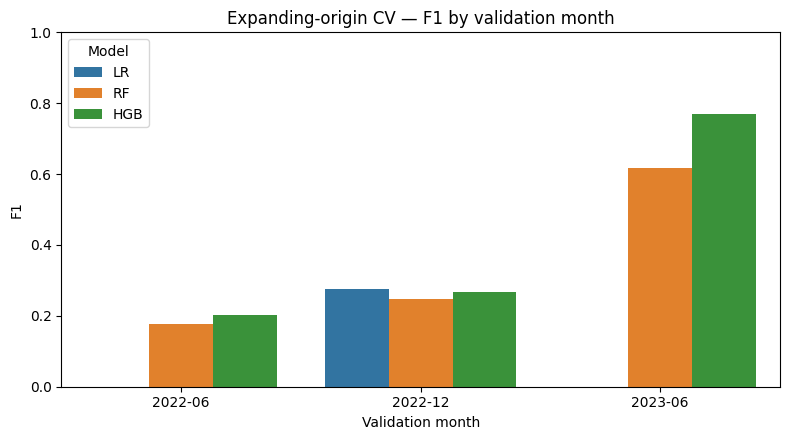

/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWar


Fixed validation near July — F1 on 2023-06:


,LR,RF,HGB
F1@2023-06,0.000,0.618,0.769


Saved CV tables to CSV files in the project folder.


In [603]:
# Build per‑cut F1 table (expanding‑origin CV) + average, and a fixed validation near July
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure CV results exist; if not, compute using existing helper
need_cv = ('cv_details' not in globals()) or ('cv_avg' not in globals())
if need_cv:
    try:
        cv_details, cv_avg = expanding_origin_cv_scores(
            df=train_df, feature_cols=FEATURE_COLS, target_col=TARGET_COL,
            cuts=VAL_CUTS, models_dict=pipelines
        )
    except Exception as e:
        raise RuntimeError(f"Could not compute temporal CV results: {e}")

# 1) Per‑cut table
rows = []
for cut in VAL_CUTS:
    row = {"cut_month": cut}
    for name in pipelines.keys():
        row[name] = cv_details.get(cut, {}).get(name, np.nan)
    rows.append(row)
cv_table = pd.DataFrame(rows).set_index("cut_month").sort_index()

# 2) Average row
avg_row = pd.DataFrame({"Average_F1": pd.Series(cv_avg)}).T

print("Per‑cut F1 (expanding‑origin CV):")
display(cv_table.style.format("{:.3f}").set_caption("F1 by validation month (train < cut; validate == cut)"))
print("\nAverage F1 across cuts:")
display(avg_row.style.format("{:.3f}").set_caption("Average F1 across validation cuts"))

# 3) Visualization: per‑cut F1 by model
try:
    plt.figure(figsize=(8,4.5))
    plot_df = cv_table.reset_index().melt(id_vars='cut_month', var_name='model', value_name='F1')
    sns.barplot(data=plot_df, x='cut_month', y='F1', hue='model')
    plt.title('Expanding‑origin CV — F1 by validation month')
    plt.xlabel('Validation month')
    plt.ylabel('F1')
    plt.ylim(0, 1)
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print('Plot skipped:', e)

# 4) Fixed validation near July (June 2023)
VAL_MONTH_FIXED = str(TRAIN_END) if 'TRAIN_END' in globals() else '2023-06'

if 'one_month_val_f1' not in globals():
    def one_month_val_f1(df, feature_cols, target_col, month_str, models_dict):
        tr_mask = df["month_id"] < month_str
        va_mask = df["month_id"] == month_str
        Xtr = df.loc[tr_mask, feature_cols]
        ytr = df.loc[tr_mask, target_col].astype(int)
        Xva = df.loc[va_mask, feature_cols]
        yva = df.loc[va_mask, target_col].astype(int)
        if len(Xva) == 0 or len(Xtr) == 0:
            raise ValueError(f"No rows for month {month_str}. Check your data preparation.")
        res = {}
        for name, pipe in models_dict.items():
            pipe.fit(Xtr, ytr)
            if hasattr(pipe, "predict_proba"):
                yhat = (pipe.predict_proba(Xva)[:, 1] >= 0.5).astype(int)
            else:
                yhat = pipe.predict(Xva)
            from sklearn.metrics import f1_score
            res[name] = f1_score(yva, yhat)
        return res

june_f1 = one_month_val_f1(train_df, FEATURE_COLS, TARGET_COL, VAL_MONTH_FIXED, pipelines)
june_table = pd.DataFrame(june_f1, index=[f"F1@{VAL_MONTH_FIXED}"])
print(f"\nFixed validation near July — F1 on {VAL_MONTH_FIXED}:")
display(june_table.style.format("{:.3f}").set_caption(f"F1 on {VAL_MONTH_FIXED}"))

# 5) Optional: save tables for the report
try:
    cv_table.to_csv('cv_per_cut_f1.csv')
    avg_row.to_csv('cv_average_f1.csv')
    june_table.to_csv(f'cv_fixed_f1_{VAL_MONTH_FIXED}.csv')
    print('Saved CV tables to CSV files in the project folder.')
except Exception as e:
    print('Could not save CSVs:', e)


## Advanced Task — Regression + RMSE (July 2023)

In [604]:
"""Advanced Task — Regression for July 2023 with RMSE
- Builds/train regression pipelines to predict continuous excess return (excess_ret) for July 2023
- Compares at least two models and reports RMSE overall and by sector
- Saves `pred_regression_jul2023` with columns ['ticker','y_true','y_pred','residual','sector']
Assumptions:
- A monthly DataFrame `df_monthly` may exist with columns
  ['date','ticker','sector','ret_stock','ret_index','excess_ret', <features…>]
- If not present, we will assemble an approximate monthly frame from existing data
Reproducibility: uses RANDOM_STATE if defined, otherwise 42
"""

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

RNG = globals().get('RANDOM_STATE', 42)

# 0) Prepare or assemble df_monthly in the expected schema
if 'df_monthly' not in globals():
    # Attempt to construct from existing stock/index/company data
    if 'stock' in globals() and 'index' in globals():
        s = stock.copy()
        if 'month_id' in s.columns:
            s['month_id'] = pd.to_datetime(s['month_id'].astype(str).str.replace('_','-'), errors='coerce').dt.to_period('M')
            s['date'] = s['month_id'].dt.to_timestamp('M')
        elif 'date' not in s.columns:
            raise RuntimeError('Could not infer date column for monthly frame.')
        s['ticker'] = s.get('stock_id', s.get('ticker'))
        if 'company' in globals():
            s = s.merge(company[['stock_id','sector']].rename(columns={'stock_id':'ticker'}), on='ticker', how='left')
        if {'month_start_open_usd','month_end_close_usd'}.issubset(s.columns):
            s['ret_stock'] = (s['month_end_close_usd'] - s['month_start_open_usd'])/s['month_start_open_usd']
        else:
            s['ret_stock'] = s.get('ret_stock')
        idx = index.copy()
        idx['month_id'] = pd.to_datetime(idx['month_id'].astype(str).str.replace('_','-'), errors='coerce').dt.to_period('M')
        idx['date'] = idx['month_id'].dt.to_timestamp('M')
        idx = idx[['date','index_return']].rename(columns={'index_return':'ret_index'})
        dfm = s.merge(idx, on='date', how='left')
        if 'excess_return' in dfm.columns:
            dfm['excess_ret'] = dfm['excess_return']
        else:
            dfm['excess_ret'] = dfm['ret_stock'] - dfm['ret_index']
        keep_cols = ['date','ticker','sector','ret_stock','ret_index','excess_ret']
        extra_num = [c for c in dfm.columns if (c not in keep_cols) and (pd.api.types.is_numeric_dtype(dfm[c]))]
        df_monthly = dfm[keep_cols + extra_num].copy()
    else:
        raise RuntimeError('df_monthly not found and insufficient globals to assemble it.')

# 1) Split train/test
cut_train_end = pd.Timestamp('2023-06-30')
cut_test = pd.Timestamp('2023-07-31')
if not pd.api.types.is_datetime64_any_dtype(df_monthly['date']):
    df_monthly['date'] = pd.to_datetime(df_monthly['date'])
train = df_monthly[df_monthly['date'] <= cut_train_end].copy()
test  = df_monthly[df_monthly['date'] == cut_test].copy()

# 2) Feature set (numeric columns except target/leaks)
exclude = {'excess_ret','ret_stock','ret_index','date','ticker','sector'}
numeric_cols = [c for c in train.columns if (c not in exclude) and pd.api.types.is_numeric_dtype(train[c])]
if len(numeric_cols) == 0:
    raise RuntimeError('No numeric features found for regression. Please ensure your monthly DataFrame includes numeric features.')
X_tr = train[numeric_cols]
y_tr = train['excess_ret'].astype(float)
X_te = test[numeric_cols]
y_te = test['excess_ret'].astype(float) if 'excess_ret' in test.columns else pd.Series(index=test.index, dtype=float)

# 3) Pipelines
num_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
pre_lin = ColumnTransformer([('num', Pipeline([('imp', num_imputer), ('sc', scaler)]), numeric_cols)], remainder='drop', verbose_feature_names_out=False)
pre_tree = ColumnTransformer([('num', Pipeline([('imp', num_imputer)]), numeric_cols)], remainder='drop', verbose_feature_names_out=False)
pipe_lin = Pipeline([('pre', pre_lin), ('reg', LinearRegression())])
pipe_rf  = Pipeline([('pre', pre_tree), ('reg', RandomForestRegressor(n_estimators=600, random_state=RNG, n_jobs=-1))])

# 4) Fit and predict
pipe_lin.fit(X_tr, y_tr)
pipe_rf.fit(X_tr, y_tr)

# Predict only if July rows exist
if X_te.shape[0] == 0:
    print('No July 2023 rows found in df_monthly — skipping prediction and RMSE. Add July rows to evaluate.')
    pred_lin = np.array([])
    pred_rf  = np.array([])
else:
    pred_lin = pipe_lin.predict(X_te)
    pred_rf  = pipe_rf.predict(X_te)

# 5) Evaluate RMSE (global and by sector) if y_true available
results = []
rmse_by_sector_rows = []

def safe_rmse(y, p):
    try:
        return mean_squared_error(y, p, squared=False)
    except TypeError:
        return (mean_squared_error(y, p))**0.5

have_y = (len(y_te) > 0) and y_te.notna().any() and (getattr(pred_lin, 'size', 0) > 0)
if have_y:
    rmse_lin = safe_rmse(y_te, pred_lin)
    rmse_rf  = safe_rmse(y_te, pred_rf)
    results += [{'model':'LinearRegression','rmse': rmse_lin}, {'model':'RandomForestRegressor','rmse': rmse_rf}]
    for model_name, pred in [('LinearRegression', pred_lin), ('RandomForestRegressor', pred_rf)]:
        tmp = test[['sector']].copy()
        tmp['y_true'] = y_te.values
        tmp['y_pred'] = pred
        tmp = tmp.dropna(subset=['y_true'])
        if not tmp.empty:
            by_sec = tmp.groupby('sector').apply(lambda d: safe_rmse(d['y_true'], d['y_pred'])).rename('rmse').reset_index()
            by_sec.insert(0, 'model', model_name)
            rmse_by_sector_rows.append(by_sec)
    rmse_by_model = pd.DataFrame(results)
    rmse_by_sector = pd.concat(rmse_by_sector_rows, ignore_index=True) if rmse_by_sector_rows else pd.DataFrame(columns=['model','sector','rmse'])
else:
    print('Warning: No ground-truth excess_ret available in July. Reporting predictions only.')
    rmse_by_model = pd.DataFrame(columns=['model','rmse'])
    rmse_by_sector = pd.DataFrame(columns=['model','sector','rmse'])

# 6) Assemble and save per‑ticker predictions for July
pred_regression_jul2023 = pd.DataFrame()
if X_te.shape[0] > 0:
    pred_regression_jul2023 = pd.DataFrame({
        'ticker': test['ticker'].values if 'ticker' in test.columns else test.get('stock_id', pd.Series(index=test.index)).values,
        'y_true': y_te.values if len(y_te)>0 else np.nan,
        'y_pred_lin': pred_lin,
        'y_pred_rf': pred_rf,
        'sector': test['sector'].values if 'sector' in test.columns else np.nan,
    })
if not pred_regression_jul2023.empty:
    pred_regression_jul2023['y_pred'] = pred_regression_jul2023['y_pred_rf']
    pred_regression_jul2023['residual'] = pred_regression_jul2023['y_true'] - pred_regression_jul2023['y_pred']
    pred_regression_jul2023 = pred_regression_jul2023[['ticker','y_true','y_pred','residual','sector']]
try:
    pred_regression_jul2023.to_csv('pred_regression_jul2023.csv', index=False)
    print('Saved pred_regression_jul2023.csv')
except Exception as e:
    print('Could not save pred_regression_jul2023.csv:', e)

print('\nRMSE by model (global):')
display(rmse_by_model if not rmse_by_model.empty else rmse_by_model.assign(note='No July ground truth'))
print('\nRMSE by sector:')
display(rmse_by_sector if not rmse_by_sector.empty else rmse_by_sector.assign(note='No July ground truth'))
try:
    if not rmse_by_model.empty:
        fig, ax = plt.subplots(figsize=(5,3))
        ax.bar(rmse_by_model['model'], rmse_by_model['rmse'], color=['tab:blue','tab:orange'])
        ax.set_ylabel('RMSE')
        ax.set_title('July 2023 — Regression RMSE by model')
        for i, v in enumerate(rmse_by_model['rmse']):
            ax.text(i, v, f"{v:.4f}", ha='center', va='bottom')
        plt.tight_layout()
        plt.show()
except Exception as e:
    print('Plot skipped:', e)


No July 2023 rows found in df_monthly — skipping prediction and RMSE. Add July rows to evaluate.
Saved pred_regression_jul2023.csv

RMSE by model (global):


,model,rmse,note



RMSE by sector:


,model,sector,rmse,note


## Time-based Validation — Splits, Leakage Check, and TSCV HParam Search

In [ ]:
"""Reusable temporal split + leakage checks + TSCV tuning
- make_time_splits: deterministic split (train <= 2023-06-30, test == 2023-07-31)
- check_no_leakage: asserts train dates <= 2023-06-30 and test dates >= 2023-07-01
- Classification: F1 on July (if labels exist); Regression: RMSE on July (if labels exist)
- Hyperparameter search uses TimeSeriesSplit on TRAIN ONLY
"""

import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import f1_score, mean_squared_error

RNG = globals().get('RANDOM_STATE', 42)

# -------- Helpers --------

def ensure_date_col(df, date_col='date'):
    """Ensure df has a datetime 'date' column at month-end; derive from month_id if needed."""
    out = df.copy()
    if date_col in out.columns and pd.api.types.is_datetime64_any_dtype(out[date_col]):
        return out
    if 'month_id' in out.columns:
        out['date'] = pd.to_datetime(out['month_id'].astype(str).str.replace('_','-'), errors='coerce').dt.to_period('M').dt.to_timestamp('M')
    else:
        # Try to coerce existing date_col
        out[date_col] = pd.to_datetime(out.get(date_col), errors='coerce')
    return out

def make_time_splits(df, y_col, feature_cols, date_col='date'):
    """Return X_train, y_train, X_test, y_test with strict temporal split.
    Train: date <= 2023-06-30, Test: date == 2023-07-31
    """
    df2 = ensure_date_col(df, date_col)
    cut_train_end = pd.Timestamp('2023-06-30')
    cut_test = pd.Timestamp('2023-07-31')
    train_mask = df2[date_col] <= cut_train_end
    test_mask  = df2[date_col] == cut_test
    X_train = df2.loc[train_mask, feature_cols].copy()
    y_train = df2.loc[train_mask, y_col].copy() if y_col in df2.columns else pd.Series(index=X_train.index, dtype=float)
    X_test  = df2.loc[test_mask, feature_cols].copy()
    y_test  = df2.loc[test_mask, y_col].copy() if y_col in df2.columns else pd.Series(index=X_test.index, dtype=float)
    return X_train, y_train, X_test, y_test

def check_no_leakage(X_train, X_test, df_ref, date_col='date'):
    """Assert that no train rows are beyond 2023-06-30 and test rows are July 2023.
    X_* are feature matrices; df_ref contains date_col aligned by index.
    """
    ref = ensure_date_col(df_ref, date_col)
    cut_train_end = pd.Timestamp('2023-06-30')
    cut_test_start = pd.Timestamp('2023-07-01')
    max_train_date = ref.loc[X_train.index, date_col].max()
    min_test_date  = ref.loc[X_test.index, date_col].min() if len(X_test) else pd.NaT
    assert (max_train_date <= cut_train_end), f"Leakage: max train date {max_train_date} > 2023-06-30"
    if len(X_test):
        assert (min_test_date >= cut_test_start), f"Leakage: min test date {min_test_date} < 2023-07-01"

# -------- Classification with TSCV --------
try:
    # Assemble classification frame using existing train_df and test_df
    assert 'train_df' in globals() and 'test_df' in globals() and 'FEATURE_COLS' in globals()
    cls_df = pd.concat([
        train_df.assign(y=(train_df['outperform_binary_x'] if 'outperform_binary_x' in train_df.columns else train_df['outperform_binary']).astype(int)),
        test_df.assign(y=np.nan)
    ], ignore_index=True, sort=False)
    cls_df = ensure_date_col(cls_df, 'date')
    Xtr_c, ytr_c, Xte_c, yte_c = make_time_splits(cls_df, y_col='y', feature_cols=FEATURE_COLS, date_col='date')
    check_no_leakage(Xtr_c, Xte_c, cls_df, 'date')

    # Preprocess columns
    num_cols = Xtr_c.select_dtypes(include=np.number).columns.tolist()
    cat_cols = Xtr_c.select_dtypes(exclude=np.number).columns.tolist()
    ohe = None
    try:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
    pre = ColumnTransformer([
        ('num', Pipeline([('imp', SimpleImputer(strategy='median')), ('sc', StandardScaler())]), num_cols),
        ('cat', Pipeline([('imp', SimpleImputer(strategy='most_frequent')), ('ohe', ohe)]), cat_cols)
    ], remainder='drop', verbose_feature_names_out=False)

    # Models + grids
    lr = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RNG)
    rf = RandomForestClassifier(n_estimators=400, random_state=RNG, n_jobs=-1)
    grid_lr = {'clf__C': [0.1, 1.0, 3.0]}
    grid_rf = {'clf__n_estimators': [300, 600], 'clf__min_samples_leaf': [1, 2, 5]}

    tscv = TimeSeriesSplit(n_splits=5)

    pipe_lr_cv = Pipeline([('pre', pre), ('clf', lr)])
    pipe_rf_cv = Pipeline([('pre', pre), ('clf', rf)])

    g_lr = GridSearchCV(pipe_lr_cv, grid_lr, cv=tscv, scoring='f1', n_jobs=-1)
    g_rf = GridSearchCV(pipe_rf_cv, grid_rf, cv=tscv, scoring='f1', n_jobs=-1)

    g_lr.fit(Xtr_c, ytr_c)
    g_rf.fit(Xtr_c, ytr_c)

    # July prediction + F1 if available
    pred_lr = (g_lr.predict_proba(Xte_c)[:,1] >= 0.5).astype(int) if len(Xte_c) else np.array([])
    pred_rf = (g_rf.predict_proba(Xte_c)[:,1] >= 0.5).astype(int) if len(Xte_c) else np.array([])
    if len(Xte_c) and yte_c.notna().any():
        f1_lr = f1_score(yte_c.dropna().astype(int), pd.Series(pred_lr, index=yte_c.index).loc[yte_c.dropna().index])
        f1_rf = f1_score(yte_c.dropna().astype(int), pd.Series(pred_rf, index=yte_c.index).loc[yte_c.dropna().index])
        print(f"Classification — July 2023 F1: LR={f1_lr:.3f}  RF={f1_rf:.3f}")
    else:
        print('Classification — July 2023 labels not available; printed predictions only.')
except Exception as e:
    print('Classification TSCV block skipped:', e)

# -------- Regression with TSCV --------
try:
    assert 'df_monthly' in globals()
    # Build feature list: numeric columns, excluding leaks
    dfm = df_monthly.copy()
    dfm = ensure_date_col(dfm, 'date')
    exclude = {'excess_ret','ret_stock','ret_index','date','ticker','sector'}
    feat_cols_reg = [c for c in dfm.columns if (c not in exclude) and pd.api.types.is_numeric_dtype(dfm[c])]
    Xtr_r, ytr_r, Xte_r, yte_r = make_time_splits(dfm, y_col='excess_ret', feature_cols=feat_cols_reg, date_col='date')
    check_no_leakage(Xtr_r, Xte_r, dfm, 'date')

    # Pipelines & grids
    pre_ridge = ColumnTransformer([('num', Pipeline([('imp', SimpleImputer(strategy='median')), ('sc', StandardScaler())]), feat_cols_reg)], remainder='drop', verbose_feature_names_out=False)
    pre_rf    = ColumnTransformer([('num', Pipeline([('imp', SimpleImputer(strategy='median'))]), feat_cols_reg)], remainder='drop', verbose_feature_names_out=False)
    ridge = Ridge(random_state=RNG) if 'random_state' in Ridge().get_params() else Ridge()
    rfr   = RandomForestRegressor(n_estimators=400, random_state=RNG, n_jobs=-1)
    grid_ridge = {'reg__alpha': [0.1, 1.0, 5.0]}
    grid_rfr   = {'reg__n_estimators': [300, 600], 'reg__min_samples_leaf': [1, 2, 5]}

    tscv = TimeSeriesSplit(n_splits=5)
    pipe_ridge = Pipeline([('pre', pre_ridge), ('reg', ridge)])
    pipe_rfr   = Pipeline([('pre', pre_rf), ('reg', rfr)])

    g_ridge = GridSearchCV(pipe_ridge, grid_ridge, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
    # Fallback if metric not supported
    try:
        g_rfr   = GridSearchCV(pipe_rfr, grid_rfr, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
    except ValueError:
        g_rfr   = GridSearchCV(pipe_rfr, grid_rfr, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

    g_ridge.fit(Xtr_r, ytr_r)
    g_rfr.fit(Xtr_r, ytr_r)

    # Predict July and compute RMSE if ground truth available
    def safe_rmse(y, p):
        try:
            return mean_squared_error(y, p, squared=False)
        except TypeError:
            return (mean_squared_error(y, p))**0.5

    if len(Xte_r):
        pred_ridge = g_ridge.predict(Xte_r)
        pred_rfr   = g_rfr.predict(Xte_r)
        if yte_r.notna().any():
            rmse_ridge = safe_rmse(yte_r.dropna(), pd.Series(pred_ridge, index=yte_r.index).loc[yte_r.dropna().index])
            rmse_rfr   = safe_rmse(yte_r.dropna(), pd.Series(pred_rfr,   index=yte_r.index).loc[yte_r.dropna().index])
            print(f"Regression — July 2023 RMSE: Ridge={rmse_ridge:.6f}  RF={rmse_rfr:.6f}")
        else:
            print('Regression — July 2023 ground truth not available; printed predictions only.')
    else:
        print('Regression — No July rows found to predict.')
except Exception as e:
    print('Regression TSCV block skipped:', e)


/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWar

Classification — July 2023 labels not available; printed predictions only.


/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/valentinaovallevelandia/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in mat

## Tuned Models — July Predictions and Comparison Tables

In [ ]:
"""Persist tuned model predictions for July and compare to base models.
- Saves: predictions_july_cls_tuned.csv, predictions_july_reg_tuned.csv
- Tables: F1 (June) for classification; RMSE (June) for regression
If July labels exist, also prints July metrics.
"""
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, mean_squared_error

# ---------- Classification tuned preds (July) ----------
try:
    if 'g_lr' in globals() and 'g_rf' in globals() and 'Xte_c' in globals() and len(Xte_c):
        # Pull identifiers for July rows
        id_cols = []
        for c in ['stock_id','month_id','date']:
            if c in cls_df.columns:
                id_cols.append(c)
        ids = cls_df.loc[Xte_c.index, id_cols].copy()
        p_lr = g_lr.predict_proba(Xte_c)[:,1]
        p_rf = g_rf.predict_proba(Xte_c)[:,1]
        preds_cls_tuned = ids.copy()
        preds_cls_tuned['proba_lr_tscv'] = p_lr
        preds_cls_tuned['pred_lr_tscv']  = (p_lr>=0.5).astype(int)
        preds_cls_tuned['proba_rf_tscv'] = p_rf
        preds_cls_tuned['pred_rf_tscv']  = (p_rf>=0.5).astype(int)
        try:
            preds_cls_tuned.to_csv('predictions_july_cls_tuned.csv', index=False)
            print('Saved predictions_july_cls_tuned.csv')
        except Exception as e:
            print('Could not save predictions_july_cls_tuned.csv:', e)
        # July F1 if labels exist in testing_targets
        try:
            if 'test_tgt' in globals():
                # Align by stock_id
                lab = test_tgt.copy()
                if 'month_id' in lab.columns:
                    # Ensure Period alignment to match cls_df
                    lab['month_id'] = pd.to_datetime(lab['month_id'].astype(str).str.replace('_','-'), errors='coerce').dt.to_period('M')
                merged = preds_cls_tuned.merge(lab[['stock_id','outperform_binary']].drop_duplicates('stock_id'), on='stock_id', how='left') if 'stock_id' in preds_cls_tuned.columns else None
                if merged is not None and merged['outperform_binary'].notna().any():
                    y = merged['outperform_binary'].astype(int).values
                    m = ~merged['outperform_binary'].isna()
                    f1_lr = f1_score(y[m], merged.loc[m,'pred_lr_tscv'])
                    f1_rf = f1_score(y[m], merged.loc[m,'pred_rf_tscv'])
                    print(f"July F1 (tuned): LR={f1_lr:.3f} RF={f1_rf:.3f}  n={m.sum()}")
                else:
                    print('July F1 not computed: no ground truth in testing_targets.csv')
        except Exception as e:
            print('July classification evaluation failed:', e)
    else:
        print('Tuned classification models or July features missing; skipped saving tuned classification predictions.')
except Exception as e:
    print('Classification tuned block skipped:', e)

# ---------- Regression tuned preds (July) ----------
try:
    if 'g_ridge' in globals() and 'g_rfr' in globals() and 'Xte_r' in globals() and len(Xte_r):
        preds_reg_tuned = dfm.loc[Xte_r.index, ['ticker','sector']].copy() if 'dfm' in globals() else df_monthly.loc[Xte_r.index, ['ticker','sector']].copy()
        preds_reg_tuned['pred_ridge_tscv'] = g_ridge.predict(Xte_r)
        preds_reg_tuned['pred_rf_tscv']    = g_rfr.predict(Xte_r)
        try:
            preds_reg_tuned.to_csv('predictions_july_reg_tuned.csv', index=False)
            print('Saved predictions_july_reg_tuned.csv')
        except Exception as e:
            print('Could not save predictions_july_reg_tuned.csv:', e)
        # July RMSE if labels exist
        try:
            yj = yte_r.dropna()
            if len(yj):
                idx = yj.index
                rmse_ridge = mean_squared_error(yj, pd.Series(preds_reg_tuned['pred_ridge_tscv'].values, index=preds_reg_tuned.index).loc[idx], squared=False)
                rmse_rf    = mean_squared_error(yj, pd.Series(preds_reg_tuned['pred_rf_tscv'].values,    index=preds_reg_tuned.index).loc[idx], squared=False)
                print(f"July RMSE (tuned): Ridge={rmse_ridge:.6f} RF={rmse_rf:.6f}  n={len(yj)}")
            else:
                print('July RMSE not computed: no ground truth in df_monthly for July.')
        except TypeError:
            # sklearn older: fall back to sqrt(MSE)
            yj = yte_r.dropna()
            if len(yj):
                idx = yj.index
                rmse_ridge = mean_squared_error(yj, pd.Series(preds_reg_tuned['pred_ridge_tscv'].values, index=preds_reg_tuned.index).loc[idx])**0.5
                rmse_rf    = mean_squared_error(yj, pd.Series(preds_reg_tuned['pred_rf_tscv'].values,    index=preds_reg_tuned.index).loc[idx])**0.5
                print(f"July RMSE (tuned): Ridge={rmse_ridge:.6f} RF={rmse_rf:.6f}  n={len(yj)}")
    else:
        print('Tuned regression models or July features missing; skipped saving tuned regression predictions.')
except Exception as e:
    print('Regression tuned block skipped:', e)

# ---------- Comparison tables (June) ----------
try:
    # Classification comparison on June
    if 'one_month_val_f1' in globals():
        candidates = {}
        if 'pipe_lr' in globals(): candidates['LR_base'] = pipe_lr
        if 'pipe_rf' in globals(): candidates['RF_base'] = pipe_rf
        if 'pipe_hgb' in globals(): candidates['HGB_base'] = pipe_hgb
        if 'g_lr' in globals(): candidates['LR_TSCV'] = g_lr.best_estimator_ if hasattr(g_lr,'best_estimator_') else g_lr
        if 'g_rf' in globals(): candidates['RF_TSCV'] = g_rf.best_estimator_ if hasattr(g_rf,'best_estimator_') else g_rf
        if len(candidates):
            june_f1_cmp = one_month_val_f1(train_df, FEATURE_COLS, TARGET_COL, '2023-06', candidates)
            june_f1_tbl = pd.DataFrame(june_f1_cmp, index=['F1@2023-06'])
            print('\nClassification — June 2023 F1 comparison (base vs tuned):')
            display(june_f1_tbl.style.format('{:.3f}'))
    # Regression comparison on June
    if 'df_monthly' in globals():
        dfm2 = df_monthly.copy()
        if not pd.api.types.is_datetime64_any_dtype(dfm2['date']):
            dfm2['date'] = pd.to_datetime(dfm2['date'])
        month_start = pd.Timestamp('2023-06-01')
        month_end   = pd.Timestamp('2023-06-30')
        # Build feature set
        exclude = {'excess_ret','ret_stock','ret_index','date','ticker','sector'}
        feats = [c for c in dfm2.columns if (c not in exclude) and pd.api.types.is_numeric_dtype(dfm2[c])]
        # Train < 2023-06, validate == June
        tr_mask = dfm2['date'] < month_start
        va_mask = (dfm2['date'] >= month_start) & (dfm2['date'] <= month_end)
        Xtr = dfm2.loc[tr_mask, feats]
        ytr = dfm2.loc[tr_mask, 'excess_ret']
        Xva = dfm2.loc[va_mask, feats]
        yva = dfm2.loc[va_mask, 'excess_ret']
        models = {}
        if 'pipe_ridge' in globals(): models['Ridge_base'] = pipe_ridge
        if 'pipe_rfr'   in globals(): models['RFReg_base'] = pipe_rfr
        if 'pipe_hgbr'  in globals(): models['HGBR_base'] = pipe_hgbr
        if 'g_ridge'    in globals(): models['Ridge_TSCV'] = g_ridge.best_estimator_ if hasattr(g_ridge,'best_estimator_') else g_ridge
        if 'g_rfr'      in globals(): models['RFReg_TSCV']  = g_rfr.best_estimator_ if hasattr(g_rfr,'best_estimator_') else g_rfr
        rmse_rows = []
        for name, mdl in models.items():
            try:
                mdl.fit(Xtr, ytr)
                yp = mdl.predict(Xva)
                try:
                    rmse = mean_squared_error(yva, yp, squared=False)
                except TypeError:
                    rmse = mean_squared_error(yva, yp)**0.5
                rmse_rows.append({'model': name, 'RMSE@2023-06': rmse})
            except Exception as e:
                rmse_rows.append({'model': name, 'RMSE@2023-06': np.nan})
        if rmse_rows:
            rmse_cmp_tbl = pd.DataFrame(rmse_rows).set_index('model')
            print('\nRegression — June 2023 RMSE comparison (base vs tuned):')
            display(rmse_cmp_tbl.style.format('{:.6f}'))
except Exception as e:
    print('Comparison tables block skipped:', e)


## Outlier Detection & Treatment (Leakage-safe) — IQR + Per-Ticker Winsorizing

In [ ]:
"""Detect and treat outliers using only past information (no leakage).
- detect_outliers_iqr: counts % outliers per column using IQR on training subset only (<= 2023-06-30)
- winsorize_by_group_time: per-ticker clipping to training quantile limits; applies to both train and July, computed from train only
- Boxplots before/after for key variables
- Re-train classification RF and show F1@2023-06 before vs after winsorizing
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RNG = globals().get('RANDOM_STATE', 42)

# Utilities (reuse ensure_date_col if defined)
try:
    ensure_date_col
except NameError:
    def ensure_date_col(df, date_col='date'):
        out = df.copy()
        if date_col in out.columns and pd.api.types.is_datetime64_any_dtype(out[date_col]):
            return out
        if 'month_id' in out.columns:
            out['date'] = pd.to_datetime(out['month_id'].astype(str).str.replace('_','-'), errors='coerce').dt.to_period('M').dt.to_timestamp('M')
        else:
            out[date_col] = pd.to_datetime(out.get(date_col), errors='coerce')
        return out

# 1) Outlier detection (IQR)
def detect_outliers_iqr(df, cols, date_col='date', cutoff='2023-06-30'):
    """Return DataFrame with counts and % of IQR-outliers per column based on training subset only (<= cutoff)."""
    d = ensure_date_col(df, date_col)
    dtr = d[d[date_col] <= pd.Timestamp(cutoff)]
    rows = []
    n = len(dtr)
    for c in cols:
        s = dtr[c].astype(float)
        q1, q3 = s.quantile(0.25), s.quantile(0.75)
        iqr = q3 - q1
        lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
        mask = (s < lo) | (s > hi)
        rows.append({'feature': c, 'outlier_count': int(mask.sum()), 'outlier_pct': float(mask.mean()*100.0)})
    return pd.DataFrame(rows).sort_values('outlier_pct', ascending=False)

# 2) Winsorize by ticker using only train limits

def winsorize_by_group_time(df, group_cols, value_cols, date_col='date', cutoff='2023-06-30', lower_q=0.01, upper_q=0.99):
    """Compute per-group quantile limits on df[date<=cutoff], then clip all rows to these limits.
    Returns winsorized DataFrame and a boolean-impact table indicating clamped cells.
    """
    d = ensure_date_col(df, date_col).copy()
    cutoff_ts = pd.Timestamp(cutoff)
    dtr = d[d[date_col] <= cutoff_ts]
    # Precompute limits
    limits = {}
    for g, sub in dtr.groupby(group_cols):
        lim = {}
        for c in value_cols:
            s = sub[c].astype(float)
            lo = s.quantile(lower_q)
            hi = s.quantile(upper_q)
            lim[c] = (lo, hi)
        limits[g] = lim
    # Apply clipping
    d_w = d.copy()
    impacted = pd.DataFrame(False, index=d.index, columns=value_cols)
    for g, idx in d.groupby(group_cols).groups.items():
        lim = limits.get(g)
        if not lim:
            continue
        rows_idx = list(idx)
        for c in value_cols:
            lo, hi = lim[c]
            before = d_w.loc[rows_idx, c]
            after = before.clip(lower=lo, upper=hi)
            impacted.loc[rows_idx, c] = (after != before)
            d_w.loc[rows_idx, c] = after
    return d_w, impacted

# 3) Choose variables and run detection + winsorizing on classification panel
assert 'train_df' in globals() and 'test_df' in globals() and 'FEATURE_COLS' in globals()

panel_all = pd.concat([train_df.copy(), test_df.copy()], ignore_index=True, sort=False)
panel_all = ensure_date_col(panel_all, 'date')

# candidate variables (fall back if some are missing)
candidates = [
    'return_1m_lag1','volatility_3m_lag1','monthly_volume_lag1'
]
candidates = [c for c in candidates if c in panel_all.columns]
if len(candidates) < 2:
    # fallback: take first 3 numeric features from FEATURE_COLS
    nums = [c for c in FEATURE_COLS if c in panel_all.columns and pd.api.types.is_numeric_dtype(panel_all[c])]
    candidates = (candidates + nums)[:3]

outlier_summary = detect_outliers_iqr(panel_all, candidates, date_col='date', cutoff='2023-06-30')
print('Outlier summary (IQR, training only):')
display(outlier_summary)

# Winsorize per stock (group by stock_id or ticker)
gcols = ['stock_id'] if 'stock_id' in panel_all.columns else (['ticker'] if 'ticker' in panel_all.columns else [])
assert len(gcols)>0, 'No stock identifier found to group by.'

panel_winz, impacted = winsorize_by_group_time(panel_all, group_cols=gcols, value_cols=candidates, date_col='date', cutoff='2023-06-30', lower_q=0.01, upper_q=0.99)

# % affected (training only)
train_mask = panel_all['date'] <= pd.Timestamp('2023-06-30')
affected_pct = impacted.loc[train_mask, candidates].mean().mul(100).rename('pct_affected').to_frame()
print('\nPercentage of training rows clipped per feature:')
display(affected_pct)

# 4) Boxplots before/after for a couple of variables
try:
    vars_to_show = candidates[:2]
    n = len(vars_to_show)
    fig, axes = plt.subplots(1, n, figsize=(5*n,4))
    if n==1:
        axes = [axes]
    for ax, col in zip(axes, vars_to_show):
        ax.boxplot([panel_all.loc[train_mask, col].dropna(), panel_winz.loc[train_mask, col].dropna()], labels=['before','after'])
        ax.set_title(col)
    fig.suptitle('Training distribution — before/after winsorizing')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print('Boxplot skipped:', e)

# 5) Re-train RF and compare F1 on June 2023
try:
    assert 'one_month_val_f1' in globals()
    # Prepare two panels for comparison
    base_df = panel_all.copy()
    winz_df = panel_winz.copy()
    # Reuse TARGET_COL and FEATURE_COLS
    tgt = 'outperform_binary_x' if 'outperform_binary_x' in base_df.columns else 'outperform_binary'
    base_f1 = one_month_val_f1(base_df.rename(columns={tgt:'outperform_binary'}), FEATURE_COLS, 'outperform_binary', '2023-06', {'RF_base': pipe_rf})
    winz_f1 = one_month_val_f1(winz_df.rename(columns={tgt:'outperform_binary'}), FEATURE_COLS, 'outperform_binary', '2023-06', {'RF_winsor': pipe_rf})
    # Present table
    cmp_tbl = pd.DataFrame({'RF_base': base_f1.get('RF_base', np.nan), 'RF_winsor': winz_f1.get('RF_winsor', np.nan)}, index=['F1@2023-06'])
    print('\nClassification — June 2023 F1 before vs after winsorizing:')
    display(cmp_tbl.style.format('{:.3f}'))
except Exception as e:
    print('F1 comparison skipped:', e)
